**В рамках анализа необходимо разработать модель, прогнозирующую вероятность снижения покупательской активности, провести сегментацию пользователей, представить предложения для удержания пользователей. Анализ проводится по четырем датасетам с данными о покупках, просмотрах, маркетинговых активностях, данными о времени пребывания на сайте, выручке и прибыльности пользователей.
План анализа:**

1) загрузка и получение общей информации о датасетах;

2) работа с пропусками, дубликатами, типами данных, названиями столбцов (выявление, обоснование сохранения/удаления, удаление), созданием новых столбцов/датасетов;

3) исследовательский анализ: визуализация посредством графиков каждого признака из датасетов, поиск закономерностей, предварительные выводы по признакам;

4) корреляционный анализ: установление корреляции признаков (входных) с целевым (покупательская активность), построение графиков, выбор признаков для работы с моделями;

5) работа с пайплайнами (констукторами) для прогноза снижения покупательской активности: разделение данных на выборки, подготовка данных, обучение, проверка качества; выбор лучшей модели, выбор метрики;

6) визуализация важности входных признаков, рекомендации для заказчика;

7) прогноз покупательской активности;

8) сегментация пользователей, выделение групп, варианты персонализированных предложений;

9) итоговые выводы.

**<h3>Загрузка данных</h3>**

In [1]:
! pip install scikit-learn==0.24.1 -q
! pip install numpy==1.20.3 -q
! pip install numba==0.54.1 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix
)    
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
!pip install phik -q
from phik import phik_matrix
!pip install shap -q
import shap
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
market = pd.read_csv('market_file.csv')
market_time = pd.read_csv('market_time.csv')
market_money = pd.read_csv('market_money.csv')
money = pd.read_csv('money.csv', sep=';', decimal = ',')

In [4]:
def display_df(df): 
    # выведем общие данные о каждом датасете: первые пять строк, число строк, тип данных, названия столбцов
    display(df.head())
    df.info()
    display(df.columns)
display_df(market)
display_df(market_time)
display_df(market_money)
display_df(money)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Index(['id', 'Период', 'минут'], dtype='object')

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Index(['id', 'Период', 'Выручка'], dtype='object')

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Index(['id', 'Прибыль'], dtype='object')

В датасете market 1300 строк, пропусков нет, рассмотреть вопрос о введении категориальных данных вместо типа object.
В датасете market_time 2600 строк (по первым строкам видно, что на один id приходится по две строки с разным периодом; необходимо далее провести проверку с датасетом market для поиска повторяющихся значений), присутствуют опечатки в названии периода, пропусков нет, типы данных присвоены верно.
В датасете market_money 3900 строк (по первым строкам видно, что на один id приходится три строки с разным периодом; необходимо провести проверку с предыдущими датасетами для поиска повторяющихся значений), пропусков нет, типы данных присвоены верно.
В датасете money  1300 строк, пропусков нет, типы данных присвоены верно.
Во всех датасетах названия столбцов соответствуют тексту задания. Далее может возникнуть необходимость включить в названия столбцов нижнее подчеркивание для связи слов (может потребоваться в случае применения метода query()).

**<h3>Предобработка данных</h3>**

**2.1. Обработаем пропуски в датасетах.**

In [5]:
def absent_df(df):
    display(df.isna().sum())
    
absent_df(market)
absent_df(market_time)
absent_df(market_money)
absent_df(money)

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id         0
Прибыль    0
dtype: int64

В датасетах явные пропуски отсутствуют.

**2.2. Проверим датасеты на дубликаты.**

In [6]:
def duble_df(df):
    display(df.duplicated().sum())
    
duble_df(market)
duble_df(market_time)
duble_df(market_money)
duble_df(money)

0

0

0

0

В датасетах явные дубликаты отсутствуют.

**2.3. Далее проверим датасеты на неявные дубликаты (по тем столбцам, где нет числовых данных); для столбцов с id подсчитаем число элементов.**

In [7]:
def exclusive_name(column):
    if column.name == 'id':
        return column.nunique()
    else:
        return column.unique()

display(exclusive_name(market['id']))
display(exclusive_name(market['Тип сервиса']))
display(exclusive_name(market['Покупательская активность']))
display(exclusive_name(market['Разрешить сообщать']))
display(exclusive_name(market['Популярная_категория']))
display(exclusive_name(market_time['id']))
display(exclusive_name(market_time['Период']))
display(exclusive_name(market_money['id']))
display(exclusive_name(market_money['Период']))
display(exclusive_name(money['id']))

1300

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

array(['Снизилась', 'Прежний уровень'], dtype=object)

array(['да', 'нет'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

1300

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

1300

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

1300

Получили информацию о том, что во всех четырых датасетах число уникальных id одинаково (1300), в то время как в датасетах market_time, market_money число строк составляет 2600 и 3900 соответственно. Ранее определили из первых строк датасетов, что имеется упоминание одного id для обозначения периода времени (текущий или предыдущий месяц), поэтому число строк увеличивается.Это означает, что время пребывания на сайте, выручка разделены построчно, а не по столбцам. Предлагается создать отдельные датасеты с помощью метода pivot().  

In [8]:
market_time_pivot = market_time.pivot(index='id', columns='Период', values='минут')
# переименуем столбцы
market_time_pivot.columns = ['Сеанс_пред_периода_минут', 'Сеанс_тек_периода_минут']
display(market_time_pivot.head())
market_time_pivot.info()

Сеанс_пред_периода_минут  Сеанс_тек_периода_минут
id                                                       
215348                        13                       14
215349                        12                       10
215350                         8                       13
215351                        11                       13
215352                         8                       11

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Сеанс_пред_периода_минут  1300 non-null   int64
 1   Сеанс_тек_периода_минут   1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


In [9]:
market_money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка')
# переименуем столбцы
market_money_pivot.columns = ['Выручка_пред_мес', 'Выручка_препред_мес', 'Выручка_тек_мес']
display(market_money_pivot.head())
market_money_pivot.info()

Выручка_пред_мес  Выручка_препред_мес  Выручка_тек_мес
id                                                            
215348               0.0                  0.0           3293.1
215349            5216.0               4472.0           4971.6
215350            5457.5               4826.0           5058.4
215351            6158.0               4793.0           6610.4
215352            5807.5               4594.0           5872.5

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Выручка_пред_мес     1300 non-null   float64
 1   Выручка_препред_мес  1300 non-null   float64
 2   Выручка_тек_мес      1300 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


Получили два новых датасета со временем пребывания на сайте и выручкой, в которых по отдельным столбцам (а не построчно) указаны продолжительность пребывания на сайте и выручка за соответствующий период, отдельных столбцов по периоду и выручке/времени нет.
Теперь во всех датасетах: market, money  и два сводных указано одинаковое число строк. ((не до конца понятно, как располагать столбцы, чтобы корректно выручка и продолжительность были указаны за соответствующий период))

Далее исключим явные дубликаты в типе сервиса.

In [10]:
market['Тип сервиса'] = market['Тип сервиса'].replace('стандартт','стандарт')
market['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

В данном разделе определили отсутсвие в датасетах пропусков, явных дубликатов. Неявным дубликатом явилось некорректное указание типа сервиса, исправление внесено. Создано две сводные таблицы с данными о времени на сайте и выручке, в которых по столбцам указаны данные параметры.

**<h3>Исследовательский анализ данных</h3>**

**3.1. Изучим статистические данные по каждому признаку в датасетах, построим графики и проведем анализ визуализированной информации. Начнем с датасета market.**

In [11]:
market.describe().T

count           mean         std  \
id                                   1300.0  215997.500000  375.421985   
Маркет_актив_6_мес                   1300.0       4.253769    1.014814   
Маркет_актив_тек_мес                 1300.0       4.011538    0.696868   
Длительность                         1300.0     601.898462  249.856289   
Акционные_покупки                    1300.0       0.319808    0.249843   
Средний_просмотр_категорий_за_визит  1300.0       3.270000    1.355350   
Неоплаченные_продукты_штук_квартал   1300.0       2.840000    1.971451   
Ошибка_сервиса                       1300.0       4.185385    1.955298   
Страниц_за_визит                     1300.0       8.176923    3.978126   

                                          min        25%        50%  \
id                                   215348.0  215672.75  215997.50   
Маркет_актив_6_мес                        0.9       3.70       4.20   
Маркет_актив_тек_мес                      3.0       4.00       4.00   
Длительность                            110.0     405.50     606.00   
Акционные_покупки                         0.0       0.17       0.24   
Средний_просмотр_категорий_за_визит       1.0       2.00       3.00   
Неоплаченные_продукты_штук_квартал        0.0       1.00       3.00   
Ошибка_сервиса                            0.0       3.00       4.00   
Страниц_за_визит                          1.0       5.00       8.00   

                                           75%        max  
id                                   216322.25  216647.00  
Маркет_актив_6_мес                        4.90       6.60  
Маркет_актив_тек_мес                      4.00       5.00  
Длительность                            806.00    1079.00  
Акционные_покупки                         0.30       0.99  
Средний_просмотр_категорий_за_визит       4.00       6.00  
Неоплаченные_продукты_штук_квартал        4.00      10.00  
Ошибка_сервиса                            6.00       9.00  
Страниц_за_визит                         11.00      20.00

Из результата применения метода describe() следует, что количественные признаки имеют различный масштаб (порядок значений различен), часть, возможно, имеет выбросы. Далее рассмотрим каждый признак по отдельности.

In [12]:
market['Маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

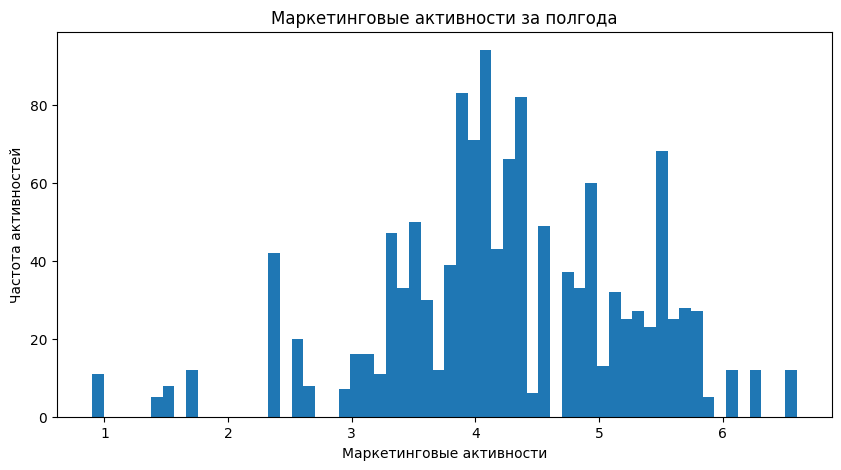

In [13]:
market['Маркет_актив_6_мес'].plot(kind='hist', bins=60, title='Маркетинговые активности за полгода', figsize=(10, 5))
plt.xlabel('Маркетинговые активности')
plt.ylabel('Частота активностей')
plt.show()

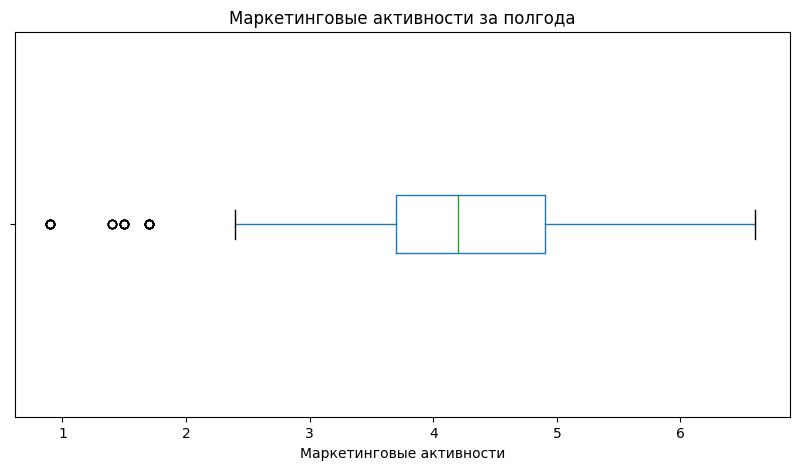

In [14]:
market['Маркет_актив_6_мес'].plot(kind='box', title='Маркетинговые активности за полгода', figsize=(10, 5), vert=False)
plt.xlabel('Маркетинговые активности')
plt.gca().set_yticklabels([])
plt.show();

In [15]:
market.query('Маркет_актив_6_мес < 2')['Маркет_актив_6_мес'].value_counts()

1.7    12
0.9    11
1.5     8
1.4     5
Name: Маркет_актив_6_мес, dtype: int64

In [16]:
market.query('Маркет_актив_6_мес == 2')['Маркет_актив_6_мес'].value_counts()

Series([], Name: Маркет_актив_6_мес, dtype: int64)

Из графиков следует, что признак маркетинговых активностей за 6 мес. кластеризован, имеет выбросы при значениях менее 2 (хотя среднее значение 4.25 близко расположено к медианному (4.2, 50%), в количестве 36. Минимальное значение - 0.9, максимальное - 6.6. Из-за кластеризации может возникнуть необходимость преобразовать признак в категориальный (этот вопрос рассмотрим отдельно при работе с пайплайнами). Выбросы сохраним, так как часть моделей к ним не чувствительна.

**3.3. Далее проведем исследовательский анализ признака 'Маркет_актив_тек_мес'.**

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

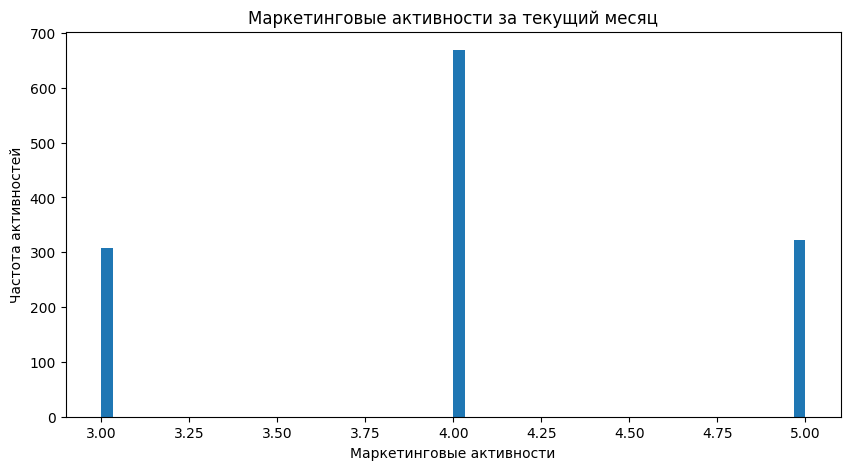

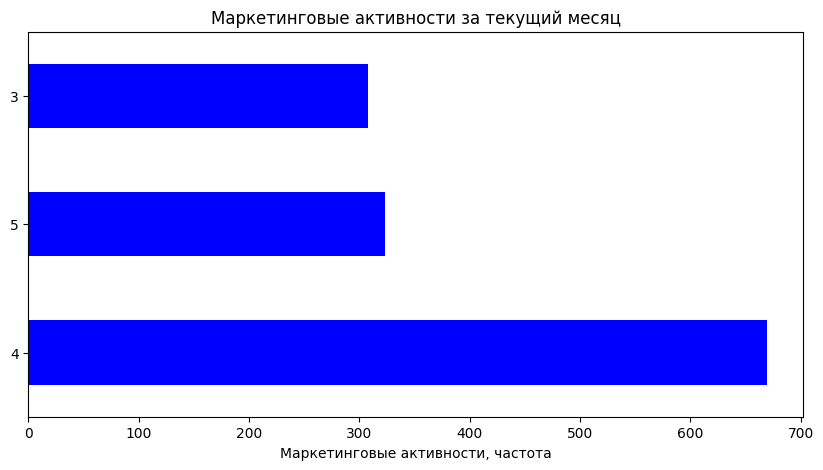

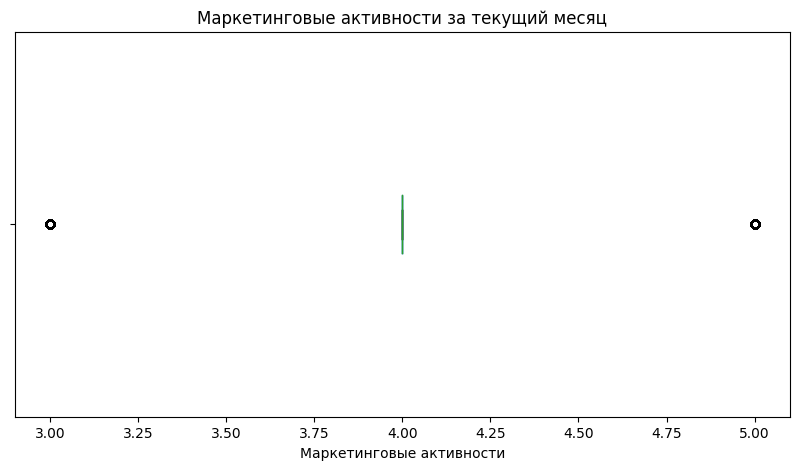

4    669
5    323
3    308
Name: Маркет_актив_тек_мес, dtype: int64

In [17]:
display(market['Маркет_актив_тек_мес'].describe())

market['Маркет_актив_тек_мес'].plot(kind='hist', bins=60, title='Маркетинговые активности за текущий месяц', figsize=(10, 5))
plt.xlabel('Маркетинговые активности')
plt.ylabel('Частота активностей')
plt.show();

market['Маркет_актив_тек_мес'].value_counts().plot(kind='barh', title='Маркетинговые активности за текущий месяц', figsize=(10, 5), color='blue')
plt.xlabel('Маркетинговые активности, частота')
plt.show()

market['Маркет_актив_тек_мес'].plot(kind='box', title='Маркетинговые активности за текущий месяц', figsize=(10, 5), vert=False)
plt.xlabel('Маркетинговые активности')
plt.gca().set_yticklabels([])
plt.show();

market['Маркет_актив_тек_мес'].unique()
market['Маркет_актив_тек_мес'].value_counts()

Из графиков следует, что за текущий месяц присутствует по три, четыре и пять маркетинговых активностей, в среднем (и по медиане) - по четыре активности. На диаграмме размаха отображены выбросы, но, как представляется, эти значения не являются выбросами, поскольку данные обозначены в виде дискретных величин. Признак подвержен кластеризации, но не может быть преобразован в категориальный, поскольку самих числовых значений может быть меньше или больше (ср. с маркетинговыми активностями за полгода). Дополнительно для данного признака построены столбчатые диаграммы, которые лучше визуализируют признак. 

**3.4. Далее проведем исследовательский анализ признака 'Длительность'.**

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

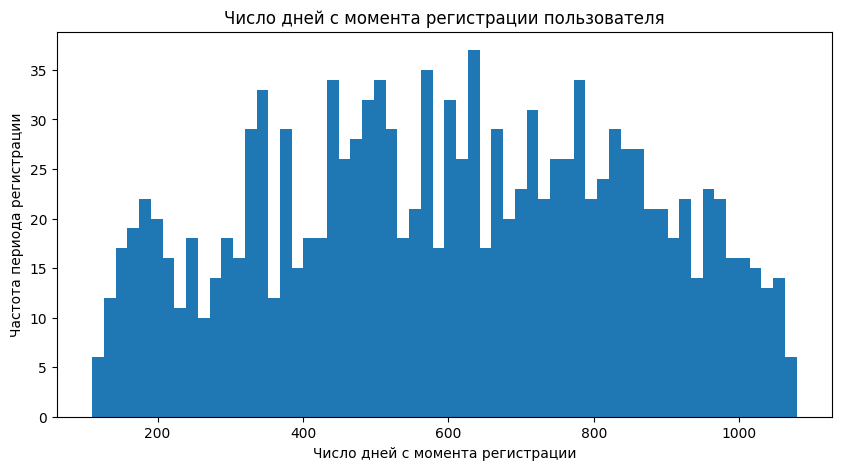

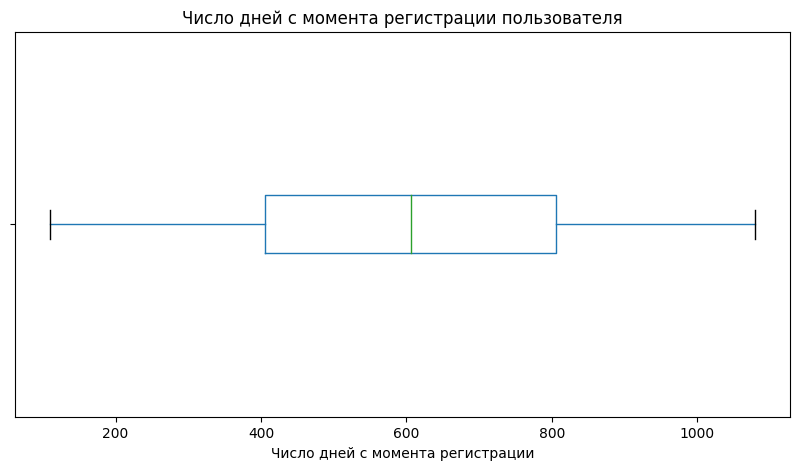

In [18]:
display(market['Длительность'].describe())

market['Длительность'].plot(kind='hist', bins=60, title='Число дней с момента регистрации пользователя', figsize=(10, 5))
plt.xlabel('Число дней с момента регистрации')
plt.ylabel('Частота периода регистрации')
plt.show();

market['Длительность'].plot(kind='box', title='Число дней с момента регистрации пользователя', figsize=(10, 5), vert=False)
plt.xlabel('Число дней с момента регистрации')
plt.gca().set_yticklabels([])
plt.show();

Выбросы для признака длительности регистрации пользователя на сайте отсутствуют (это также подтверждается почти совпадающими данными по среднему значению (602) и медиане (606); распределение ассиметрично (присутствует несколько пиков). Все пользователи зарегистрированы на сайте более трех месяцев (минимальное значение длительности - 110 дней).

**3.5. Далее проведем исследовательский анализ признака 'Акционные_покупки'.**

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

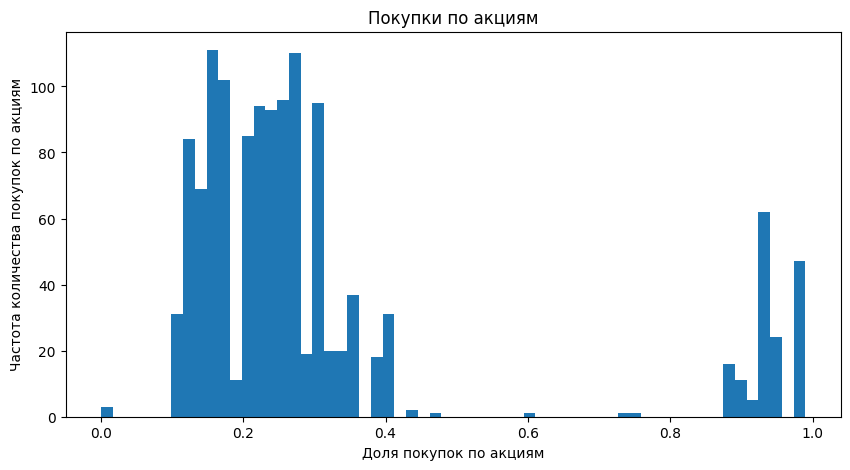

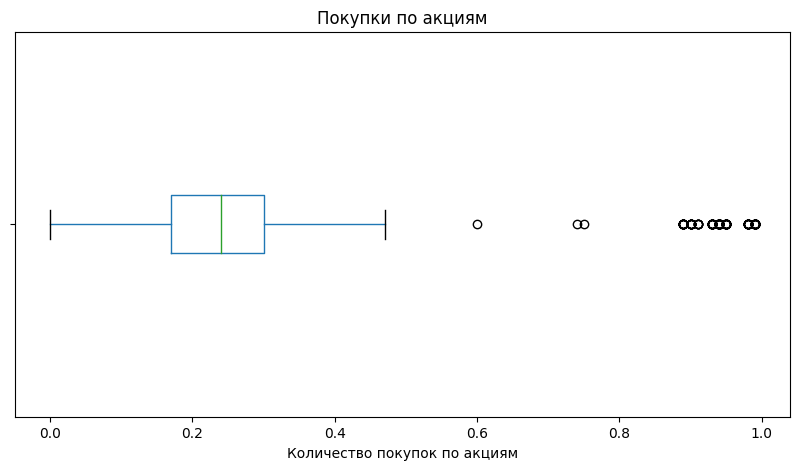

0.94    43
0.99    30
0.95    24
0.93    19
0.98    17
0.89    16
0.90    11
0.91     5
0.74     1
0.75     1
0.47     1
0.60     1
Name: Акционные_покупки, dtype: int64

In [19]:
display(market['Акционные_покупки'].describe())

market['Акционные_покупки'].plot(kind='hist', bins=60, title='Покупки по акциям', figsize=(10, 5))
plt.xlabel('Доля покупок по акциям')
plt.ylabel('Частота количества покупок по акциям')
plt.show();

market['Акционные_покупки'].plot(kind='box', title='Покупки по акциям', figsize=(10, 5), vert=False)
plt.xlabel('Количество покупок по акциям')
plt.gca().set_yticklabels([])
plt.show();

display(market.query('Акционные_покупки > 0.45')['Акционные_покупки'].value_counts())

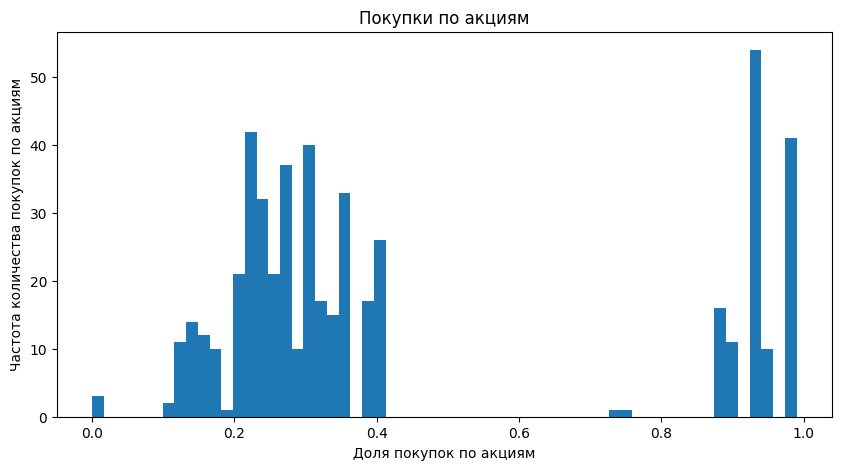

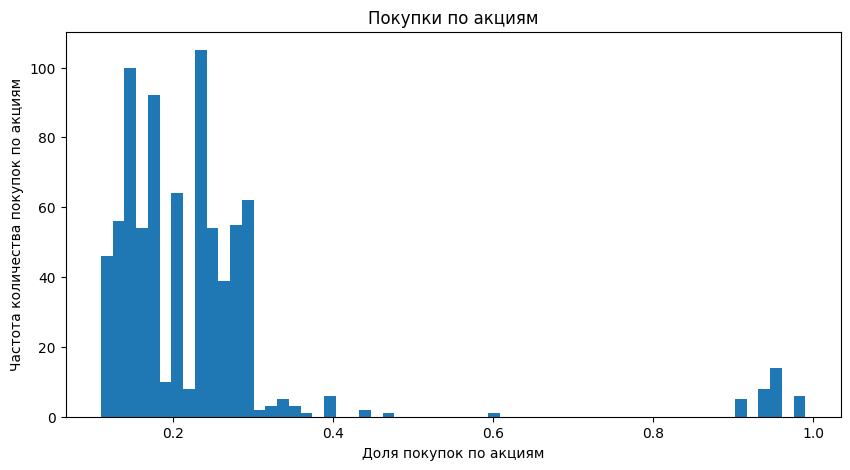

In [20]:
market.loc[market['Покупательская активность'] == 'Снизилась', 'Акционные_покупки'].plot(kind='hist', bins=60, title='Покупки по акциям', figsize=(10, 5))
plt.xlabel('Доля покупок по акциям')
plt.ylabel('Частота количества покупок по акциям')
plt.show();

market.loc[market['Покупательская активность'] == 'Прежний уровень', 'Акционные_покупки'].plot(kind='hist', bins=60, title='Покупки по акциям', figsize=(10, 5))
plt.xlabel('Доля покупок по акциям')
plt.ylabel('Частота количества покупок по акциям')
plt.show();


Акционные покупки кластеризованы (т.е. присутствует нелинейная связь с целевым признаком). Есть и такие пользователи, у которых доля акционных покупок достигает 0.99 (то есть почти все товары такие клиенты покупают по акции). Выбросы отсутствуют, т.к. все значения более 0.45 одновременно не превышают максимальное значение 0.99. Далее признак может быть преобразован в категориальный (доля покупок по акциям до 0.5 и выше 0.5). Однако построенные дополнительные графики не подтверждают основания для категоризации акционных покупок, поскольку разные значения покупательской активности характерны для всех представленных значений долей покупок по акциям в общей величине покупок. 

**3.6. Далее проведем исследовательский анализ признака 'Средний_просмотр_категорий_за_визит'.**

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

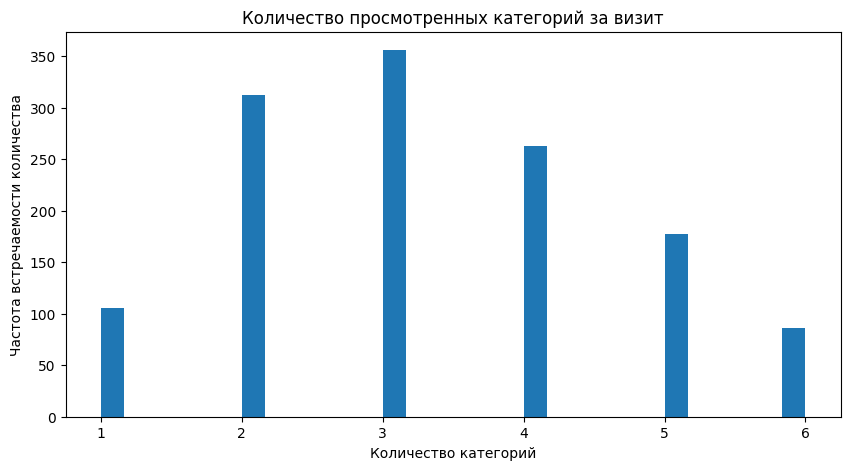

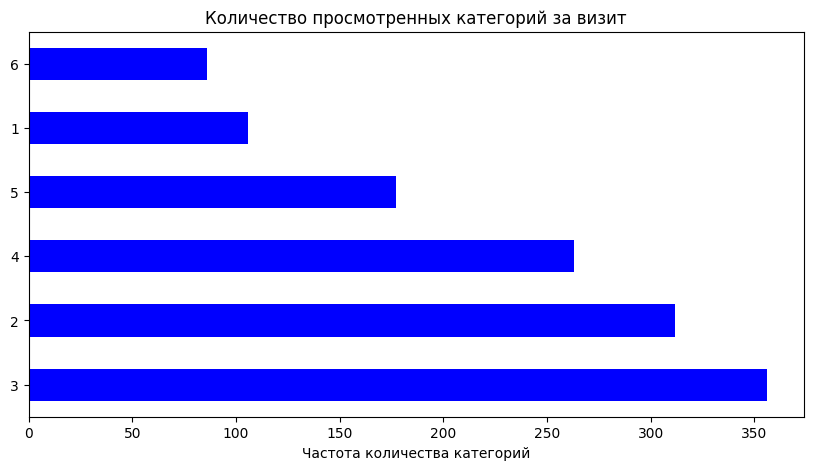

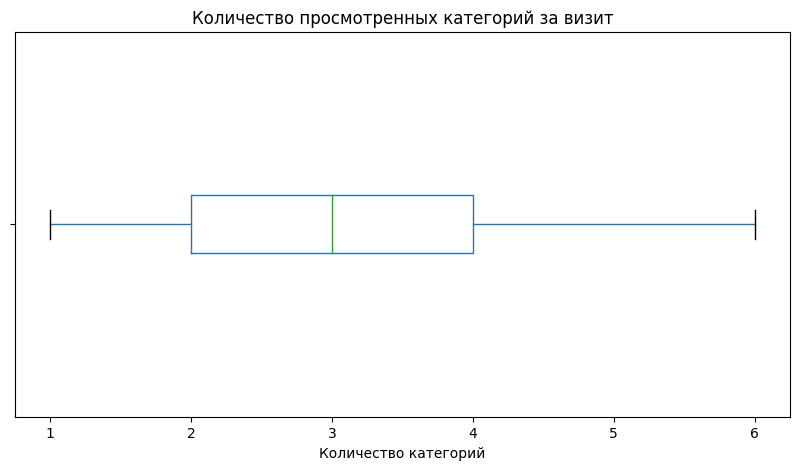

3    356
2    312
4    263
5    177
1    106
6     86
Name: Средний_просмотр_категорий_за_визит, dtype: int64

In [21]:
display(market['Средний_просмотр_категорий_за_визит'].describe())

market['Средний_просмотр_категорий_за_визит'].plot(kind='hist', bins=30, title='Количество просмотренных категорий за визит', figsize=(10, 5))
plt.xlabel('Количество категорий')
plt.ylabel('Частота встречаемости количества')
plt.show();

market['Средний_просмотр_категорий_за_визит'].value_counts().plot(kind='barh', title='Количество просмотренных категорий за визит', figsize=(10, 5), color='blue')
plt.xlabel('Частота количества категорий')
plt.show()

market['Средний_просмотр_категорий_за_визит'].plot(kind='box', title='Количество просмотренных категорий за визит', figsize=(10, 5), vert=False)
plt.xlabel('Количество категорий')
plt.gca().set_yticklabels([])
plt.show();

market['Средний_просмотр_категорий_за_визит'].value_counts()

В количестве просмотренных за один визит категорий выбросов нет, но данные кластеризованы, для наглядности постороены столбчатые диаграммы.
Минимально пользователи просматривают одну категорию товаров, максимально - шесть (все представленные категории). Интересно посмотреть на пользователей, которые одновременно интересуются всеми категориями (каковы их покупки). До 50% пользователей просматривают три категории товаров (медианное значение).

**3.7. Далее проведем исследовательский анализ признака 'Неоплаченные_продукты_штук_квартал'.**

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

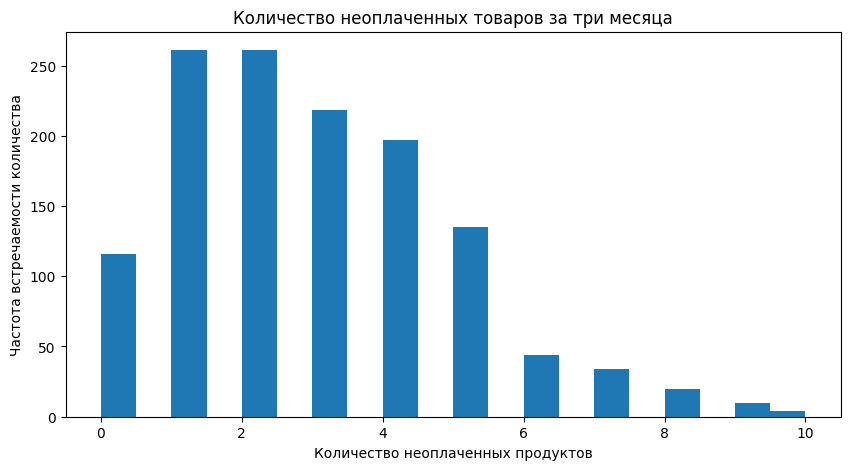

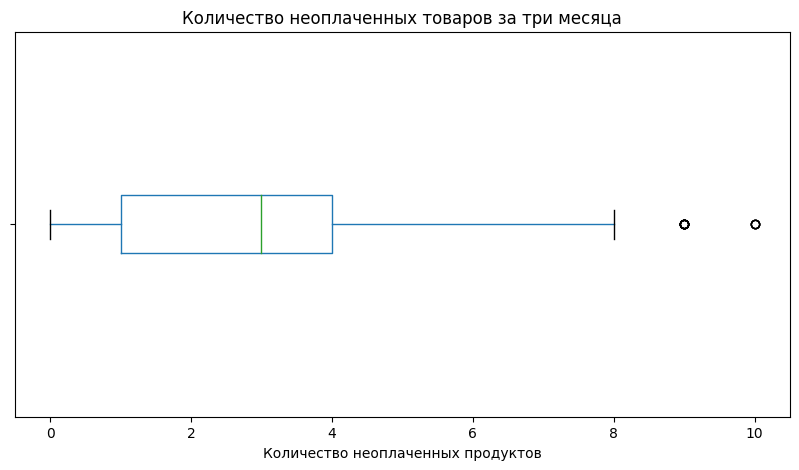

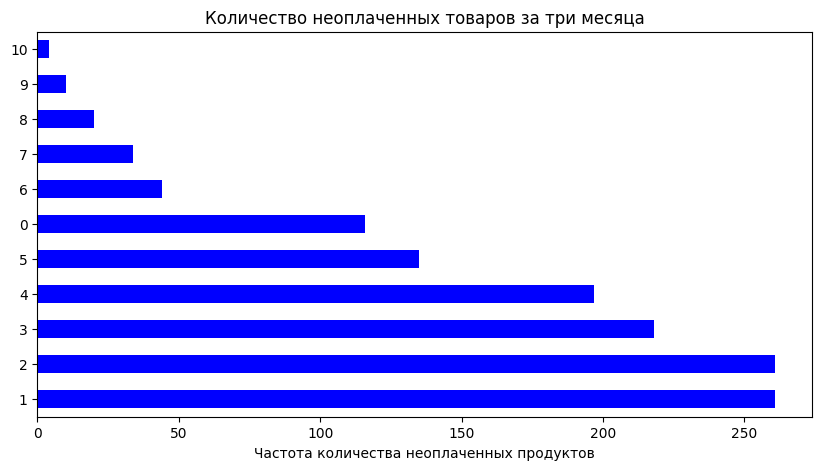

1184

1     261
2     261
3     218
4     197
5     135
6      44
7      34
8      20
9      10
10      4
Name: Неоплаченные_продукты_штук_квартал, dtype: int64

0.9107692307692308

1     261
2     261
3     218
4     197
5     135
0     116
6      44
7      34
8      20
9      10
10      4
Name: Неоплаченные_продукты_штук_квартал, dtype: int64

0    116
Name: Неоплаченные_продукты_штук_квартал, dtype: int64

28

In [22]:
display(market['Неоплаченные_продукты_штук_квартал'].describe())

market['Неоплаченные_продукты_штук_квартал'].plot(kind='hist', bins=20, title='Количество неоплаченных товаров за три месяца', figsize=(10, 5))
plt.xlabel('Количество неоплаченных продуктов')
plt.ylabel('Частота встречаемости количества')
plt.show();

market['Неоплаченные_продукты_штук_квартал'].plot(kind='box', title='Количество неоплаченных товаров за три месяца', figsize=(10, 5), vert=False)
plt.xlabel('Количество неоплаченных продуктов')
plt.gca().set_yticklabels([])
plt.show();

market['Неоплаченные_продукты_штук_квартал'].value_counts().plot(kind='barh', title='Количество неоплаченных товаров за три месяца', figsize=(10, 5), color='blue')
plt.xlabel('Частота количества неоплаченных продуктов')
plt.show()

display(market.query('Неоплаченные_продукты_штук_квартал > 0')['id'].nunique())
display(market.query('Неоплаченные_продукты_штук_квартал > 0')['Неоплаченные_продукты_штук_квартал'].value_counts())
display(market.query('Неоплаченные_продукты_штук_квартал > 0')['Неоплаченные_продукты_штук_квартал'].count() / len(market))
display(market['Неоплаченные_продукты_штук_квартал'].value_counts())
display(market.query('Неоплаченные_продукты_штук_квартал == 0')['Неоплаченные_продукты_штук_квартал'].value_counts())
market.query('Неоплаченные_продукты_штук_квартал >= 6 and Страниц_за_визит > 5')['id'].count()

На гистограмме присутствует ассиметричное распределение; дополнительно построены столбчатые диаграммы. Из 1300 уникальных пользователей неоплаченные товары (то есть можем разумно преположить, что частично это и брошенные корзины в целом) за квартал имеют 1184 пользователя, на каждого приходится по одной брошенной корзине (если не рассматривать случаи возврата товаров). До 50% пользователей не оплачивают по три товара. По данным Tinkoff eCommerce за сентябрь-октябрь 2023 года средний процент брошенных корзин составляет 70%:<https://www.tinkoff.ru/about/news/28112023-tinkoff-ecommerce-research-70percent-of-carts-remain-unpaid-in-russian-online-stores/>. В данном магазине это число достигает 91%(!) за квартал (если пока рассматриваем неоплаченные товары как брошенные корзины; если под неоплаченными товарами также иметь в виду возвращенные товары, то ситуация для магазина не лучше, поскольку встает вопрос о причинах возврата; с учетом категорий продаваемых товаров одной из основных причин неоплаты при возврате может быть неудовлетворительное качество). Проблемы могут быть как с самим магазином (например, в порядке оформления заказа), так и носить внешний характер (например, конкуренты предлагают такие же товары дешевле). Часть пользователей не оплачивают по 8-10 товаров; с учетом того, что пользователи потратили время на сайте, сформировали заказ (предположим, что на значимую сумму, с учетом числа товаров), но затем отказались от него, эту группу пользователей (хоть ее корзины частично относятся к данным-выбросам) необходимо изучить дополнительно. Если число просмотренных страниц сайта более пяти (исходим из того, что осуществляется просмотр следующих страниц: главная, каталог, карточка товара, корзина, заказ) и не оплачено от шести товаров, то таким условиям соответствуют 28 пользователей (около двух процентов всех пользователей), а с учетом размера их корзины выручка от них может быть больше их доли в общем числе пользователей. Только 116 пользователей не имеют неоплаченных товаров.

**3.8. Далее проведем исследовательский анализ признака 'Ошибка_сервиса'.**

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

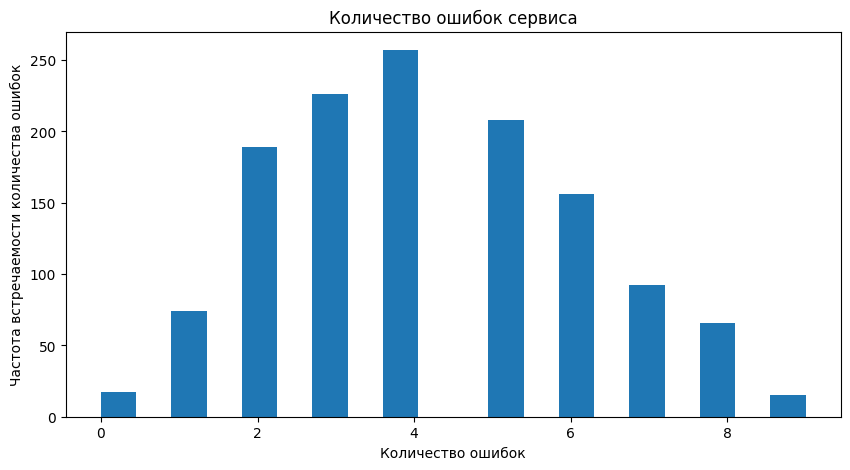

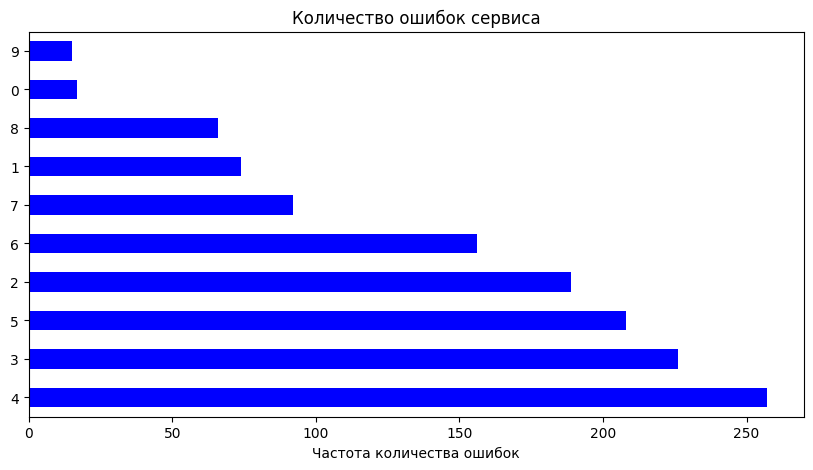

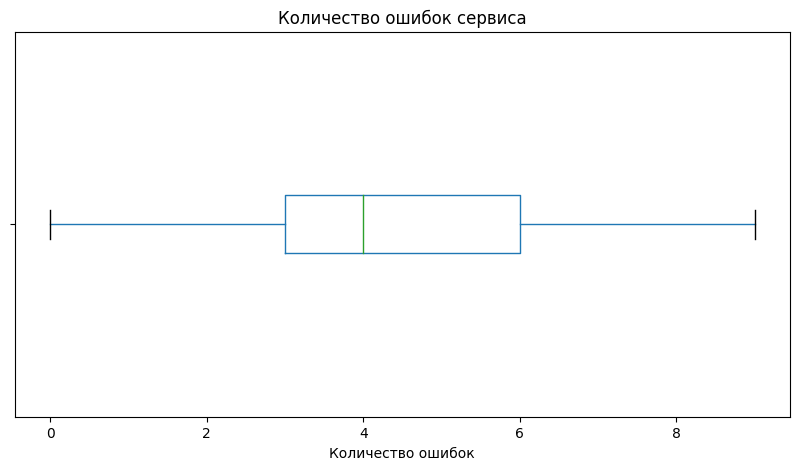

In [23]:
display(market['Ошибка_сервиса'].describe())

market['Ошибка_сервиса'].plot(kind='hist', bins=20, title='Количество ошибок сервиса', figsize=(10, 5))
plt.xlabel('Количество ошибок')
plt.ylabel('Частота встречаемости количества ошибок')
plt.show();

market['Ошибка_сервиса'].value_counts().plot(kind='barh', title='Количество ошибок сервиса', figsize=(10, 5), color='blue')
plt.xlabel('Частота количества ошибок')
plt.show()

market['Ошибка_сервиса'].plot(kind='box', title='Количество ошибок сервиса', figsize=(10, 5), vert=False)
plt.xlabel('Количество ошибок')
plt.gca().set_yticklabels([])
plt.show();


По ошибкам сервиса выбросов нет, чаще присутствует четыре ошибки. Для визуализации признака дополнительно использованы столбчатые диаграммы. По условиям задания ошибки сервиса включают те, которые затронули пользователей, то есть стали для них очевидны. Это тоже сигнал заказчику для усиления удержания пользователей. 

**3.9. Далее проведем исследовательский анализ признака 'Страниц_за_визит'.**

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

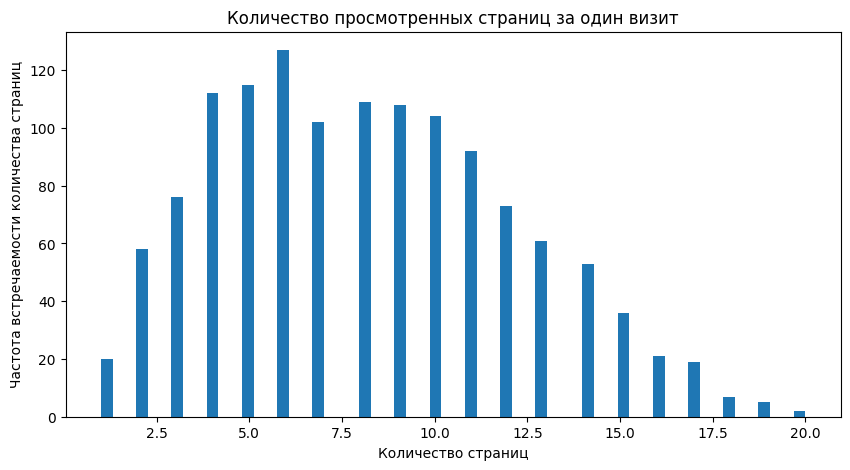

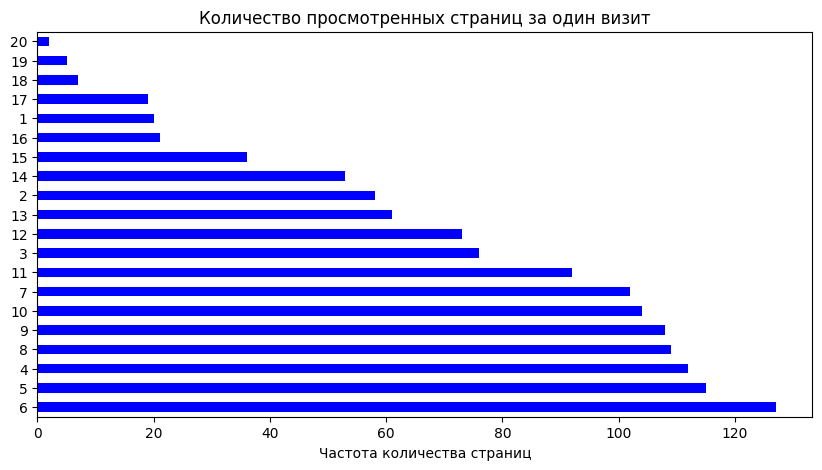

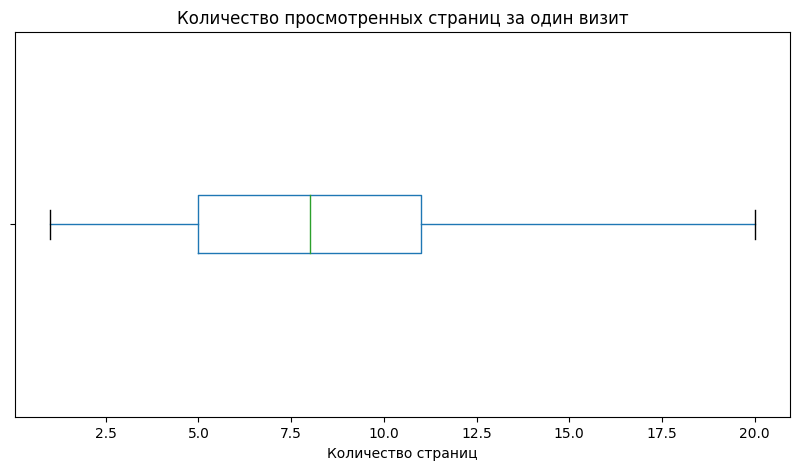

20

In [24]:
display(market['Страниц_за_визит'].describe())

market['Страниц_за_визит'].plot(kind='hist', bins=60, title='Количество просмотренных страниц за один визит', figsize=(10, 5))
plt.xlabel('Количество страниц')
plt.ylabel('Частота встречаемости количества страниц')
plt.show();

market['Страниц_за_визит'].value_counts().plot(kind='barh', title='Количество просмотренных страниц за один визит', figsize=(10, 5), color='blue')
plt.xlabel('Частота количества страниц')
plt.show()

market['Страниц_за_визит'].plot(kind='box', title='Количество просмотренных страниц за один визит', figsize=(10, 5), vert=False)
plt.xlabel('Количество страниц')
plt.gca().set_yticklabels([])
plt.show();

market.query('Страниц_за_визит == 1')['Страниц_за_визит'].count()

По числу просмотренных за визит страниц выбросов нет. Минимальное число страниц (одна страница) просмотрело двадцать пользователей. Дополнительно постороены столбчатые диаграммы для визуализации частоты просмотров конкретного числа страниц. Наиболее часто пользователи просматривают по шесть страниц, что соответствует главной странице, каталогу, карточке товара (1-2 товара), корзине, форме заказа.

**3.10. Далее проведем исследовательский анализ категориальных признаков; начнем с признака 'Покупательская активность'.**

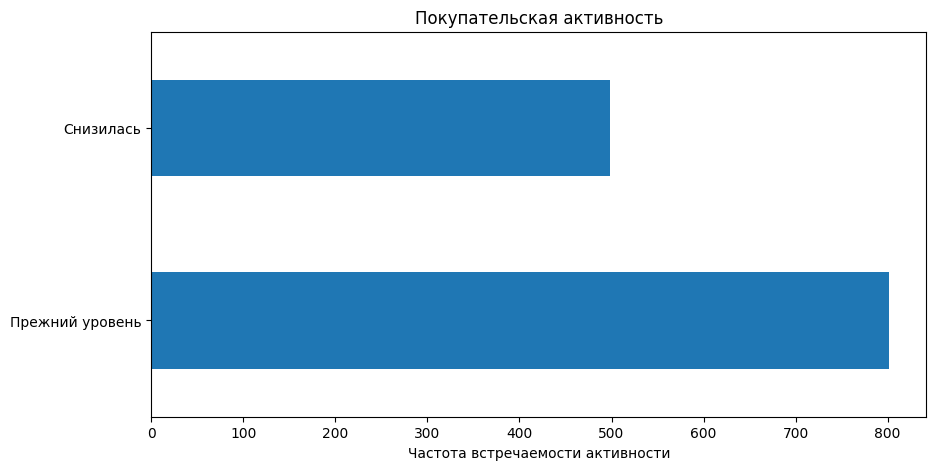

In [25]:
market['Покупательская активность'].value_counts().plot(kind='barh', title='Покупательская активность', figsize=(10, 5))
plt.xlabel('Частота встречаемости активности')
plt.show()

Из графика следует снижение покупательской активности 500 пользователей. Присутствует дисбаланс класса (при работе с моделями нужно провести стратификацию, использовать метрику roc_auc).

**3.11. Далее проведем исследовательский анализ признака 'Тип сервиса'.**

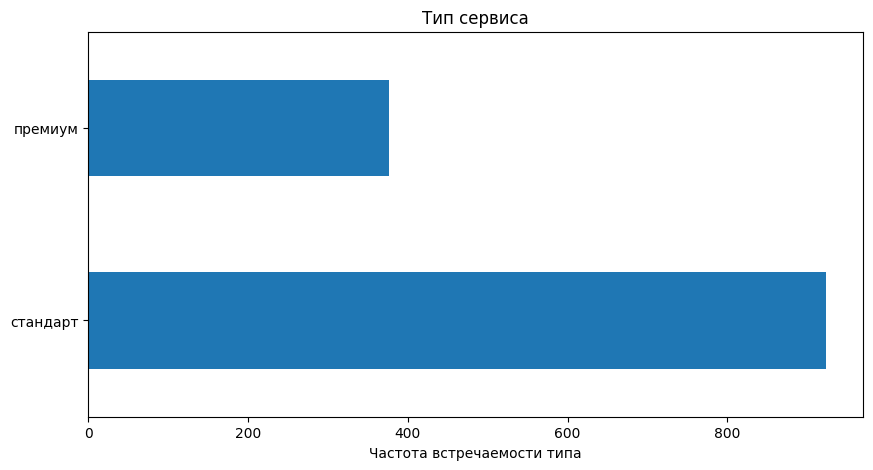

In [26]:
market['Тип сервиса'].value_counts().plot(kind='barh', title='Тип сервиса', figsize=(10, 5))
plt.xlabel('Частота встречаемости типа')
plt.show()

Менее трети пользователей используют премиум-сервис.

**3.12. Далее проведем исследовательский анализ признака 'Разрешить сообщать'.**

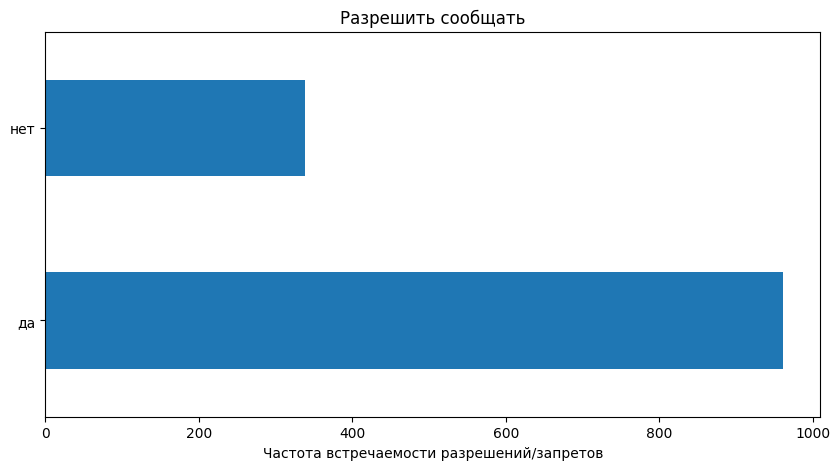

In [27]:
market['Разрешить сообщать'].value_counts().plot(kind='barh', title='Разрешить сообщать', figsize=(10, 5))
plt.xlabel('Частота встречаемости разрешений/запретов')
plt.show()

Почти тысяча пользователей дали согласие на получение уведомлений от интернет-магазина.

**3.13. Далее проведем исследовательский времени пребывания на сайте из сводной таблицы market_time_pivot.**

Сеанс_пред_периода_минут  Сеанс_тек_периода_минут
count               1300.000000              1300.000000
mean                  13.467692                13.204615
std                    3.932029                 4.220589
min                    5.000000                 4.000000
25%                   11.000000                10.000000
50%                   13.000000                13.000000
75%                   17.000000                16.000000
max                   23.000000                23.000000

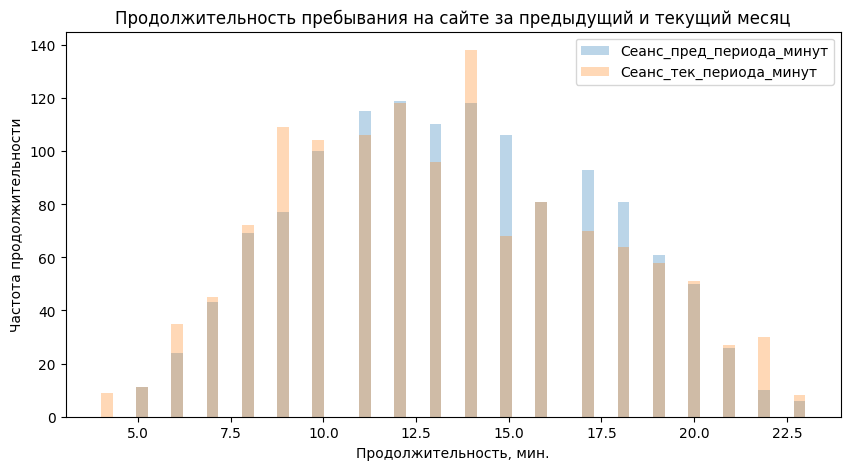

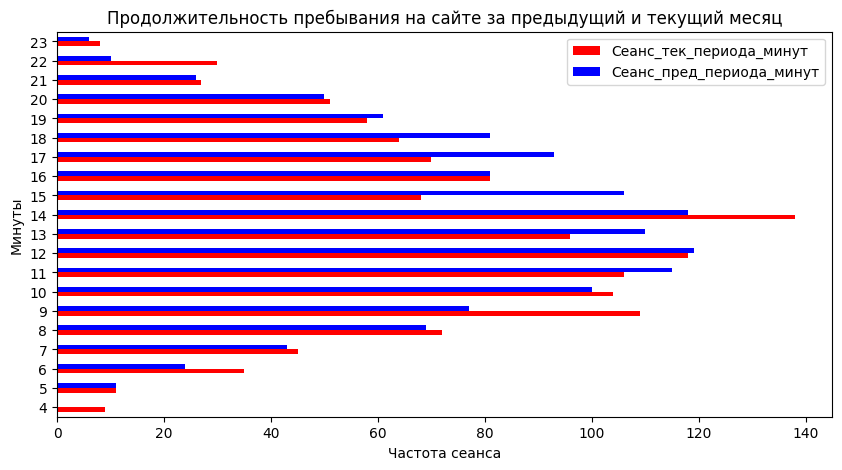

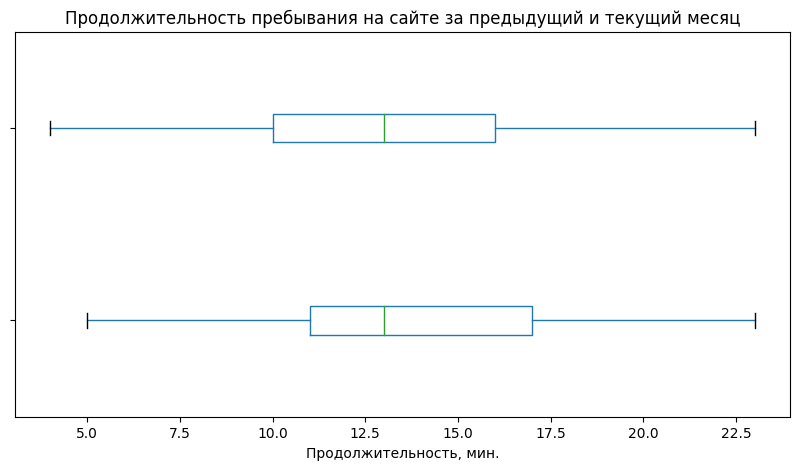

4    9
Name: Сеанс_тек_периода_минут, dtype: int64

5    11
Name: Сеанс_пред_периода_минут, dtype: int64

In [28]:

display(market_time_pivot.describe())

market_time_pivot.plot(kind='hist', bins=60, alpha=0.3, title='Продолжительность пребывания на сайте за предыдущий и текущий месяц', figsize=(10, 5))
plt.xlabel('Продолжительность, мин.')
plt.ylabel('Частота продолжительности')
plt.show();

market_time_pivot[['Сеанс_тек_периода_минут', 'Сеанс_пред_периода_минут']].apply(pd.Series.value_counts).plot(kind='barh', color=['red', 'blue'], title='Продолжительность пребывания на сайте за предыдущий и текущий месяц', figsize=(10, 5))
plt.xlabel('Частота сеанса')
plt.ylabel('Минуты')
plt.show()

market_time_pivot.plot(kind='box', title='Продолжительность пребывания на сайте за предыдущий и текущий месяц', figsize=(10, 5), vert=False)
plt.xlabel('Продолжительность, мин.')
plt.gca().set_yticklabels([])
plt.show();

display(market_time_pivot.query('Сеанс_тек_периода_минут <=4')['Сеанс_тек_периода_минут'].value_counts())
market_time_pivot.query('Сеанс_пред_периода_минут <= 5')['Сеанс_пред_периода_минут'].value_counts()

По продолжительности пребывания на сайте за оба месяца выбросов нет, медианные значения равны и близки к средним. Для двадцати случаев посещение сайта занимало до 4-5 минут. Дополнительно использованы столбчатые диаграммы для визуализации.

**3.14. Далее проведем исследовательский анализ времени выручки из сводной таблицы market_money_pivot.**

Выручка_пред_мес  Выручка_препред_мес  Выручка_тек_мес
count       1300.000000          1300.000000      1300.000000
mean        4936.920385          4825.206923      5314.960846
std          739.597997           405.979663      2939.708156
min            0.000000             0.000000      2758.700000
25%         4496.750000          4583.000000      4706.050000
50%         5005.000000          4809.000000      5179.950000
75%         5405.625000          5053.500000      5761.725000
max         6869.500000          5663.000000    106862.200000

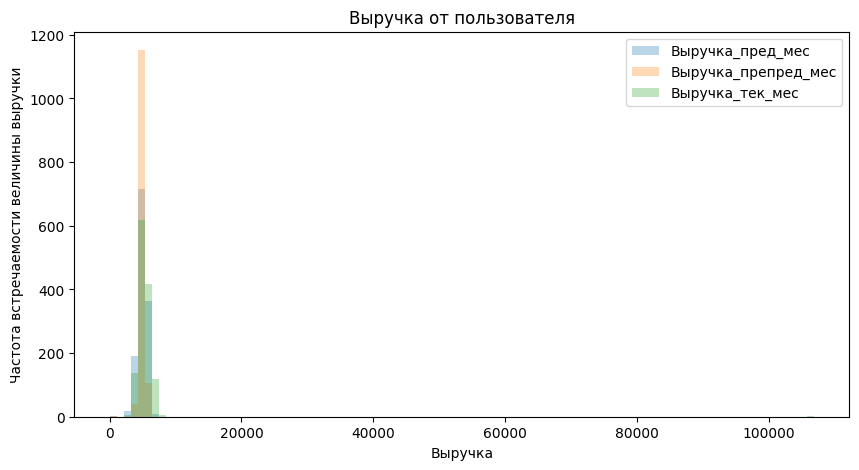

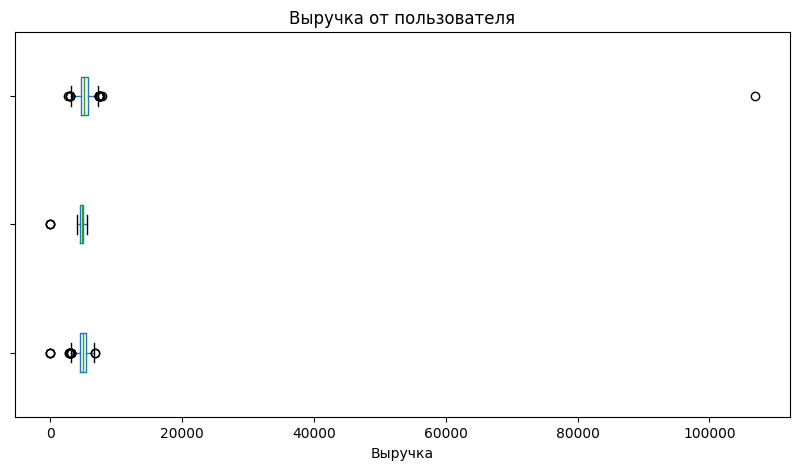

106862.2    1
Name: Выручка_тек_мес, dtype: int64

Выручка_пред_мес  Выручка_препред_мес  Выручка_тек_мес
id                                                            
215380            6077.0               5051.0         106862.2

id Покупательская активность Тип сервиса Разрешить сообщать  \
32  215380                 Снизилась     премиум                нет   

    Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
32                 1.7                     4           637               0.94   

              Популярная_категория  Средний_просмотр_категорий_за_визит  \
32  Техника для красоты и здоровья                                    3   

    Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
32                                   2               4                 7

id  Прибыль
32  215380     3.88

id               Период   Выручка
96  215380  препредыдущий_месяц    5051.0
97  215380     предыдущий_месяц    6077.0
98  215380        текущий_месяц  106862.2

In [29]:
display(market_money_pivot.describe())

market_money_pivot.plot(kind='hist', bins=100, alpha=0.3, title='Выручка от пользователя', figsize=(10, 5))
plt.xlabel('Выручка')
plt.ylabel('Частота встречаемости величины выручки')
plt.show();

market_money_pivot.plot(kind='box', title='Выручка от пользователя', figsize=(10, 5), vert=False)
plt.xlabel('Выручка')
plt.gca().set_yticklabels([])
plt.show();

display(market_money_pivot.query('Выручка_тек_мес >= 10000')['Выручка_тек_мес'].value_counts())
display(market_money_pivot.query('Выручка_тек_мес == 106862.2'))
display(market.query('id == 215380'))
display(money.query('id == 215380'))
display(market_money.query('id == 215380'))

По пользователю с id 215380 по проверенным данным (включая сводные датасеты и датасет до применения метода pivot()) указано, что покупательская способность снизилась, однако выручка за текущий месяц значимо превышает выручку за два предшествующих месяца. Если считаем, что целевой признак указан корректно, в выручке за текущий месяц присутствует ошибка. Предлагается изменить размер выручки с 106862.2 на 1068.622 (эта величина не превышает показатели за два предыдущих месяца, но больше минимального значения за текущий месяц). 

In [30]:
market_money_pivot['Выручка_тек_мес'] = market_money_pivot['Выручка_тек_мес'].replace(106862.2, 1068.622).astype(float)
market_money_pivot.query('Выручка_тек_мес == 1068.622')

Выручка_пред_мес  Выручка_препред_мес  Выручка_тек_мес
id                                                            
215380            6077.0               5051.0         1068.622

Выручка_пред_мес  Выручка_препред_мес  Выручка_тек_мес
count       1300.000000          1300.000000      1300.000000
mean        4936.920385          4825.206923      5233.581171
std          739.597997           405.979663       843.116190
min            0.000000             0.000000      1068.622000
25%         4496.750000          4583.000000      4703.850000
50%         5005.000000          4809.000000      5179.550000
75%         5405.625000          5053.500000      5759.275000
max         6869.500000          5663.000000      7799.400000

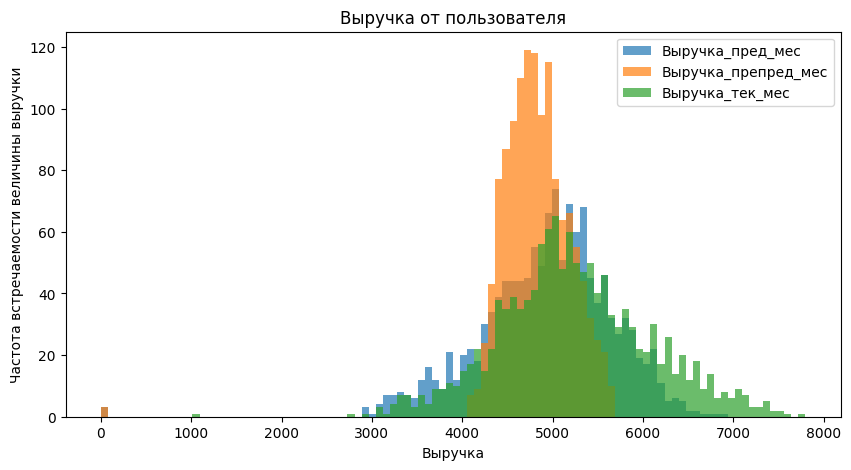

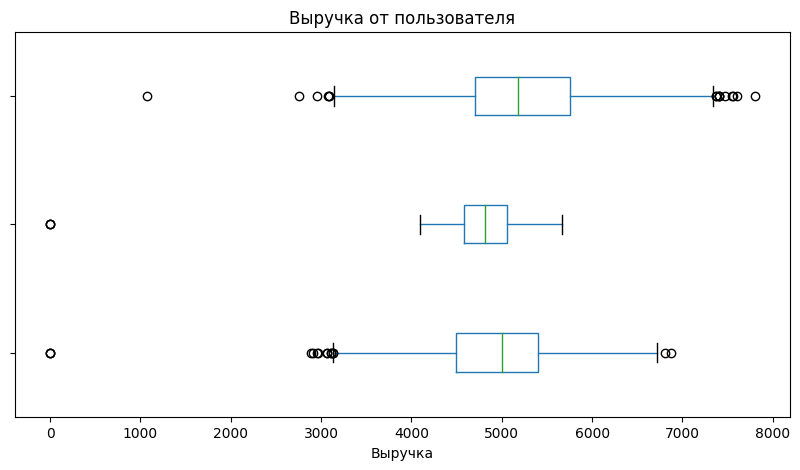

In [31]:
display(market_money_pivot.describe())

market_money_pivot.plot(kind='hist', bins=100, alpha=0.7, title='Выручка от пользователя', figsize=(10, 5))
plt.xlabel('Выручка')
plt.ylabel('Частота встречаемости величины выручки')
plt.show();

market_money_pivot.plot(kind='box', title='Выручка от пользователя', figsize=(10, 5), vert=False)
plt.xlabel('Выручка')
plt.gca().set_yticklabels([])
plt.show();


По выручке в каждом месяце присутствуют выбросы (сохраним их, т.к. часть моделей имеют устойчивость к выбросам). Распределение близко к нормальному.

In [32]:
market.query("@market_money['Выручка'] !=0")['id'].count() 
# определим, сколько пользователей совершают покупки

1294

Таким образом, 1294 из 1300 пользователей совершали покупки за последние три месяца (каждый из пользователей зарегистрирован более трех месяцев).

In [33]:
market.query("@market_money['Выручка'] == 0")
# выведем данные по всем пользователям, у которых за три месяца нет покупок

id Покупательская активность Тип сервиса Разрешить сообщать  \
0   215348                 Снизилась     премиум                 да   
2   215350                 Снизилась    стандарт                нет   
28  215376                 Снизилась    стандарт                 да   
29  215377                 Снизилась    стандарт                 да   
34  215382                 Снизилась    стандарт                 да   
35  215383                 Снизилась    стандарт                 да   

    Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                  3.4                     5           121               0.00   
2                  4.9                     3           539               0.14   
28                 2.4                     3           534               0.98   
29                 4.6                     4           730               0.27   
34                 4.6                     4           330               0.89   
35                 2.7                     4           504               0.33   

              Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                 Товары для детей                                    6   
2                Домашний текстиль                                    5   
28               Домашний текстиль                                    4   
29                Товары для детей                                    2   
34  Техника для красоты и здоровья                                    6   
35  Техника для красоты и здоровья                                    2   

    Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                    2               1                 5  
2                                    2               1                 5  
28                                   1               5                 4  
29                                   5               8                 5  
34                                   2               7                 6  
35                                   4               2                 4

Из датасета market исключим тех пользователей, у которых нет покупок (выручка от них равна нулю) за последние три месяца.

In [34]:
market = market.query("@market_money['Выручка'] !=0")
display(market.head())
market.info()

id Покупательская активность Тип сервиса Разрешить сообщать  \
1  215349                 Снизилась     премиум                 да   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   
5  215353                 Снизилась    стандарт                 да   
6  215354                 Снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
1                 4.4                     4           819               0.75   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   

    Популярная_категория  Средний_просмотр_категорий_за_визит  \
1       Товары для детей                                    4   
3       Товары для детей                                    5   
4       Товары для детей                                    3   
5      Домашний текстиль                                    4   
6  Косметика и аксесуары                                    2   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
1                                   4               2                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1294 non-null   int64  
 1   Покупательская активность            1294 non-null   object 
 2   Тип сервиса                          1294 non-null   object 
 3   Разрешить сообщать                   1294 non-null   object 
 4   Маркет_актив_6_мес                   1294 non-null   float64
 5   Маркет_актив_тек_мес                 1294 non-null   int64  
 6   Длительность                         1294 non-null   int64  
 7   Акционные_покупки                    1294 non-null   float64
 8   Популярная_категория                 1294 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1294 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1294 non-null   int64  
 11  Ошибка_сервиса                

Обнаружена кластеризация по маркетинговым активностям за полгода, акционным покупкам, что означает наличие нелинейной связи с целевым признаком покупательской активности.
По одному из покупателей, основываясь на снижении покупательской активности, изменены данные по выручке за текущий месяц.
Определили, что 1294 из 1300 пользователей совершали покупки за последние три месяца, в датасете cохранили данные только об активных покупателях.
Визуализацию по популярным категориям проведем в разделе 8 при сегментации пользователей (во избежание дублирования, т.к. в разделе 8 подробно остановимся на разбивке по категориям приобретаемых товаров).

**<h3>Объединение датасетов</h3>**

In [35]:
market = market.set_index('id')
# сделаем из столбца с id индексы строк, чтобы затем по индексам методом join() объединить датасеты market, market_time_pivot, 
# market_money_pivot

Сначала объединим датасеты market, market_time_pivot.
Используем способ объединения 'left', чтобы включить все данные датасета market, из которого удалили неактивных в течение трех месяцев пользователей.

In [36]:
market_fulltime = market.join(market_time_pivot, on='id', how='left')
display(market_fulltime.head())
market_fulltime.info()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   
215354                 Снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   
215354                 5.1                     3           431   

        Акционные_покупки   Популярная_категория  \
id                                                 
215349               0.75       Товары для детей   
215351               0.99       Товары для детей   
215352               0.94       Товары для детей   
215353               0.26      Домашний текстиль   
215354               0.23  Косметика и аксесуары   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215351                                    5   
215352                                    3   
215353                                    4   
215354                                    2   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   
215354                                   3               7                 2   

        Сеанс_пред_периода_минут  Сеанс_тек_периода_минут  
id                                                         
215349                        12                       10  
215351                        11                       13  
215352                         8                       11  
215353                        10                       10  
215354                        11                       12

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 215349 to 216647
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1294 non-null   object 
 1   Тип сервиса                          1294 non-null   object 
 2   Разрешить сообщать                   1294 non-null   object 
 3   Маркет_актив_6_мес                   1294 non-null   float64
 4   Маркет_актив_тек_мес                 1294 non-null   int64  
 5   Длительность                         1294 non-null   int64  
 6   Акционные_покупки                    1294 non-null   float64
 7   Популярная_категория                 1294 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1294 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1294 non-null   int64  
 10  Ошибка_сервиса                       1294 non-null   int64  
 11  Страниц_за_визит       

In [37]:
market_final = market_fulltime.join(market_money_pivot, on='id', how='left')
# объединим "объединенный" датасет market_full_time  с датаестом market_money_pivot
display(market_final.head())
market_final.info()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   
215354                 Снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   
215354                 5.1                     3           431   

        Акционные_покупки   Популярная_категория  \
id                                                 
215349               0.75       Товары для детей   
215351               0.99       Товары для детей   
215352               0.94       Товары для детей   
215353               0.26      Домашний текстиль   
215354               0.23  Косметика и аксесуары   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215351                                    5   
215352                                    3   
215353                                    4   
215354                                    2   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   
215354                                   3               7                 2   

        Сеанс_пред_периода_минут  Сеанс_тек_периода_минут  Выручка_пред_мес  \
id                                                                            
215349                        12                       10            5216.0   
215351                        11                       13            6158.0   
215352                         8                       11            5807.5   
215353                        10                       10            4738.5   
215354                        11                       12            5685.0   

        Выручка_препред_мес  Выручка_тек_мес  
id                                            
215349               4472.0           4971.6  
215351               4793.0           6610.4  
215352               4594.0           5872.5  
215353               5124.0           5388.5  
215354               4503.0           5869.6

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1294 non-null   object 
 1   Тип сервиса                          1294 non-null   object 
 2   Разрешить сообщать                   1294 non-null   object 
 3   Маркет_актив_6_мес                   1294 non-null   float64
 4   Маркет_актив_тек_мес                 1294 non-null   int64  
 5   Длительность                         1294 non-null   int64  
 6   Акционные_покупки                    1294 non-null   float64
 7   Популярная_категория                 1294 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1294 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1294 non-null   int64  
 10  Ошибка_сервиса                       1294 non-null   int64  
 11  Страниц_за_визит       

Получили объединный датасет, в котором присутствуют данные по продолжительности посещения сайта и выручке за несколько месяцев.

**<h3>Корреляционный анализ</h3>**

Построим матрицу корреляции количественных и категориальных признаков. Дополнительно определим столбцы с непрерывными признаками для корректной работы матрицы.

In [38]:
interval_cols = [
    'Маркет_актив_6_мес', 'Акционные_покупки', 'Выручка_пред_мес', 'Выручка_препред_мес', 'Выручка_тек_мес'
]
# Выполнение анализа с учетом параметра interval_cols
phik_matrix = market_final.phik_matrix(interval_cols=interval_cols)
phik_matrix
#market_final.phik_matrix() # выведем матрицу корреляции с учетом наличия в датасете категориальных признаков

Покупательская активность  Тип сервиса  \
Покупательская активность                             1.000000     0.135663   
Тип сервиса                                           0.135663     1.000000   
Разрешить сообщать                                    0.000000     0.286421   
Маркет_актив_6_мес                                    0.545862     0.096075   
Маркет_актив_тек_мес                                  0.000000     0.046144   
Длительность                                          0.000000     0.611346   
Акционные_покупки                                     0.497941     0.053153   
Популярная_категория                                  0.299081     0.064370   
Средний_просмотр_категорий_за_визит                   0.541745     0.184140   
Неоплаченные_продукты_штук_квартал                    0.405514     0.115507   
Ошибка_сервиса                                        0.219350     0.078816   
Страниц_за_визит                                      0.746295     0.089573   
Сеанс_пред_периода_минут                              0.601434     0.125737   
Сеанс_тек_периода_минут                               0.567686     0.061513   
Выручка_пред_мес                                      0.155282     0.042630   
Выручка_препред_мес                                   0.476846     0.101339   
Выручка_тек_мес                                       0.161353     0.069957   

                                     Разрешить сообщать  Маркет_актив_6_мес  \
Покупательская активность                      0.000000            0.545862   
Тип сервиса                                    0.286421            0.096075   
Разрешить сообщать                             1.000000            0.000000   
Маркет_актив_6_мес                             0.000000            1.000000   
Маркет_актив_тек_мес                           0.050842            0.073993   
Длительность                                   0.614914            0.000000   
Акционные_покупки                              0.000000            0.244721   
Популярная_категория                           0.072981            0.152355   
Средний_просмотр_категорий_за_визит            0.071216            0.208338   
Неоплаченные_продукты_штук_квартал             0.162221            0.218275   
Ошибка_сервиса                                 0.000000            0.137143   
Страниц_за_визит                               0.096841            0.371756   
Сеанс_пред_периода_минут                       0.063620            0.323481   
Сеанс_тек_периода_минут                        0.000000            0.327984   
Выручка_пред_мес                               0.000000            0.092089   
Выручка_препред_мес                            0.000000            0.231837   
Выручка_тек_мес                                0.000000            0.180290   

                                     Маркет_актив_тек_мес  Длительность  \
Покупательская активность                        0.000000      0.000000   
Тип сервиса                                      0.046144      0.611346   
Разрешить сообщать                               0.050842      0.614914   
Маркет_актив_6_мес                               0.073993      0.000000   
Маркет_актив_тек_мес                             1.000000      0.682010   
Длительность                                     0.682010      1.000000   
Акционные_покупки                                0.000000      0.621078   
Популярная_категория                             0.124059      0.757958   
Средний_просмотр_категорий_за_визит              0.242241      0.767753   
Неоплаченные_продукты_штук_квартал               0.141616      0.849180   
Ошибка_сервиса                                   0.120763      0.670581   
Страниц_за_визит                                 0.000000      0.515815   
Сеанс_пред_периода_минут                         0.167114      0.148937   
Сеанс_тек_периода_минут                          0.077073      0.678559   
Выручка_пред_мес                                 0.063775      0.6

По матрице на покупательскую активность не влияют (коэффицент равен нулю) наличие разрешений на уведомление, маркетинговые активности в текущем месяце, длительность регистрации. Наибольшая связь покупательской активности имеется со следующими признаками: количество страниц за визит (0.75), продолжительность просмотра в предыдущий период (0.6), продолжительность просмотра в текущем периоде (0.57), маркетинговые активности за полгода (0.55), количество просмотренных категорий (0.54), акционные покупки (0.5). Мультиколлинеарность входных признаков отсутствует (коэффициенты не превышают 0.9). 

In [39]:
subset_decreased = market_final[market_final['Покупательская активность'] == 'Снизилась']
decreased = subset_decreased.phik_matrix(interval_cols=interval_cols)
display(decreased)


subset_same_level = market_final[market_final['Покупательская активность'] == 'Прежний уровень']
same_level = subset_same_level.phik_matrix(interval_cols=interval_cols)
same_level

C:\Anaconda\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(


Тип сервиса  Разрешить сообщать  \
Тип сервиса                             1.000000            0.261749   
Разрешить сообщать                      0.261749            1.000000   
Маркет_актив_6_мес                      0.126401            0.000000   
Маркет_актив_тек_мес                    0.000000            0.020736   
Длительность                            0.779037            0.786096   
Акционные_покупки                       0.083790            0.000000   
Популярная_категория                    0.096694            0.204710   
Средний_просмотр_категорий_за_визит     0.217013            0.000000   
Неоплаченные_продукты_штук_квартал      0.133927            0.137332   
Ошибка_сервиса                          0.131625            0.000000   
Страниц_за_визит                        0.112579            0.112477   
Сеанс_пред_периода_минут                0.153439            0.093074   
Сеанс_тек_периода_минут                 0.060915            0.000000   
Выручка_пред_мес                        0.031770            0.067140   
Выручка_препред_мес                     0.193024            0.053494   
Выручка_тек_мес                         0.031688            0.000000   

                                     Маркет_актив_6_мес  Маркет_актив_тек_мес  \
Тип сервиса                                    0.126401              0.000000   
Разрешить сообщать                             0.000000              0.020736   
Маркет_актив_6_мес                             1.000000              0.215564   
Маркет_актив_тек_мес                           0.215564              1.000000   
Длительность                                   0.000000              0.824347   
Акционные_покупки                              0.206534              0.000000   
Популярная_категория                           0.192673              0.161363   
Средний_просмотр_категорий_за_визит            0.218046              0.332039   
Неоплаченные_продукты_штук_квартал             0.156646              0.183007   
Ошибка_сервиса                                 0.086429              0.161308   
Страниц_за_визит                               0.360586              0.172448   
Сеанс_пред_периода_минут                       0.337163              0.248396   
Сеанс_тек_периода_минут                        0.276857              0.314986   
Выручка_пред_мес                               0.061984              0.049420   
Выручка_препред_мес                            0.290468              0.061073   
Выручка_тек_мес                                0.186289              0.000000   

                                     Длительность  Акционные_покупки  \
Тип сервиса                              0.779037           0.083790   
Разрешить сообщать                       0.786096           0.000000   
Маркет_актив_6_мес                       0.000000           0.206534   
Маркет_актив_тек_мес                     0.824347           0.000000   
Длительность                             1.000000           0.806491   
Акционные_покупки                        0.806491           1.000000   
Популярная_категория                     0.881240           0.151326   
Средний_просмотр_категорий_за_визит      0.926077           0.069720   
Неоплаченные_продукты_штук_квартал       0.927049           0.168330   
Ошибка_сервиса                           0.767536           0.292004   
Страниц_за_визит                         0.853242           0.294187   
Сеанс_пред_периода_минут                 0.713182           0.385603   
Сеанс_тек_периода_минут                  0.544849           0.379464   
Выручка_пред_мес                         0.802155           0.629513   
Выручка_препред_мес                      0.866283           0.896009   
Выручка_тек_мес                          0.000000           0.071290   

                                     Популярная_категория  \
Тип сервиса                                      0.096694   
Разрешить сообщать                               0.204710   
Маркет_актив_6_мес        

C:\Anaconda\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(


Тип сервиса  Разрешить сообщать  \
Тип сервиса                             1.000000            0.293044   
Разрешить сообщать                      0.293044            1.000000   
Маркет_актив_6_мес                      0.000000            0.038701   
Маркет_актив_тек_мес                    0.056050            0.067547   
Длительность                            0.507653            0.370744   
Акционные_покупки                       0.000000            0.063418   
Популярная_категория                    0.000000            0.000000   
Средний_просмотр_категорий_за_визит     0.133683            0.115093   
Неоплаченные_продукты_штук_квартал      0.069945            0.170493   
Ошибка_сервиса                          0.000000            0.024660   
Страниц_за_визит                        0.175517            0.148224   
Сеанс_пред_периода_минут                0.000000            0.000000   
Сеанс_тек_периода_минут                 0.174702            0.000000   
Выручка_пред_мес                        0.158301            0.000000   
Выручка_препред_мес                     0.000000            0.030468   
Выручка_тек_мес                         0.115690            0.000000   

                                     Маркет_актив_6_мес  Маркет_актив_тек_мес  \
Тип сервиса                                    0.000000              0.056050   
Разрешить сообщать                             0.038701              0.067547   
Маркет_актив_6_мес                             1.000000              0.159854   
Маркет_актив_тек_мес                           0.159854              1.000000   
Длительность                                   0.733391              0.571800   
Акционные_покупки                              0.101504              0.056968   
Популярная_категория                           0.126105              0.254070   
Средний_просмотр_категорий_за_визит            0.000000              0.205234   
Неоплаченные_продукты_штук_квартал             0.000000              0.147220   
Ошибка_сервиса                                 0.138019              0.146153   
Страниц_за_визит                               0.213741              0.000000   
Сеанс_пред_периода_минут                       0.000000              0.000000   
Сеанс_тек_периода_минут                        0.048295              0.067813   
Выручка_пред_мес                               0.351770              0.000000   
Выручка_препред_мес                            0.192076              0.000000   
Выручка_тек_мес                                0.040376              0.000000   

                                     Длительность  Акционные_покупки  \
Тип сервиса                              0.507653           0.000000   
Разрешить сообщать                       0.370744           0.063418   
Маркет_актив_6_мес                       0.733391           0.101504   
Маркет_актив_тек_мес                     0.571800           0.056968   
Длительность                             1.000000           0.000000   
Акционные_покупки                        0.000000           1.000000   
Популярная_категория                     0.593924           0.000000   
Средний_просмотр_категорий_за_визит      0.464617           0.000000   
Неоплаченные_продукты_штук_квартал       0.833472           0.032153   
Ошибка_сервиса                           0.739858           0.030268   
Страниц_за_визит                         0.000000           0.000000   
Сеанс_пред_периода_минут                 0.583741           0.000000   
Сеанс_тек_периода_минут                  0.704615           0.000000   
Выручка_пред_мес                         0.000000           0.000000   
Выручка_препред_мес                      0.572967           0.000000   
Выручка_тек_мес                          0.507549           0.073573   

                                     Популярная_категория  \
Тип сервиса                                      0.000000   
Разрешить сообщать                               0.000000   
Маркет_актив_6_мес        

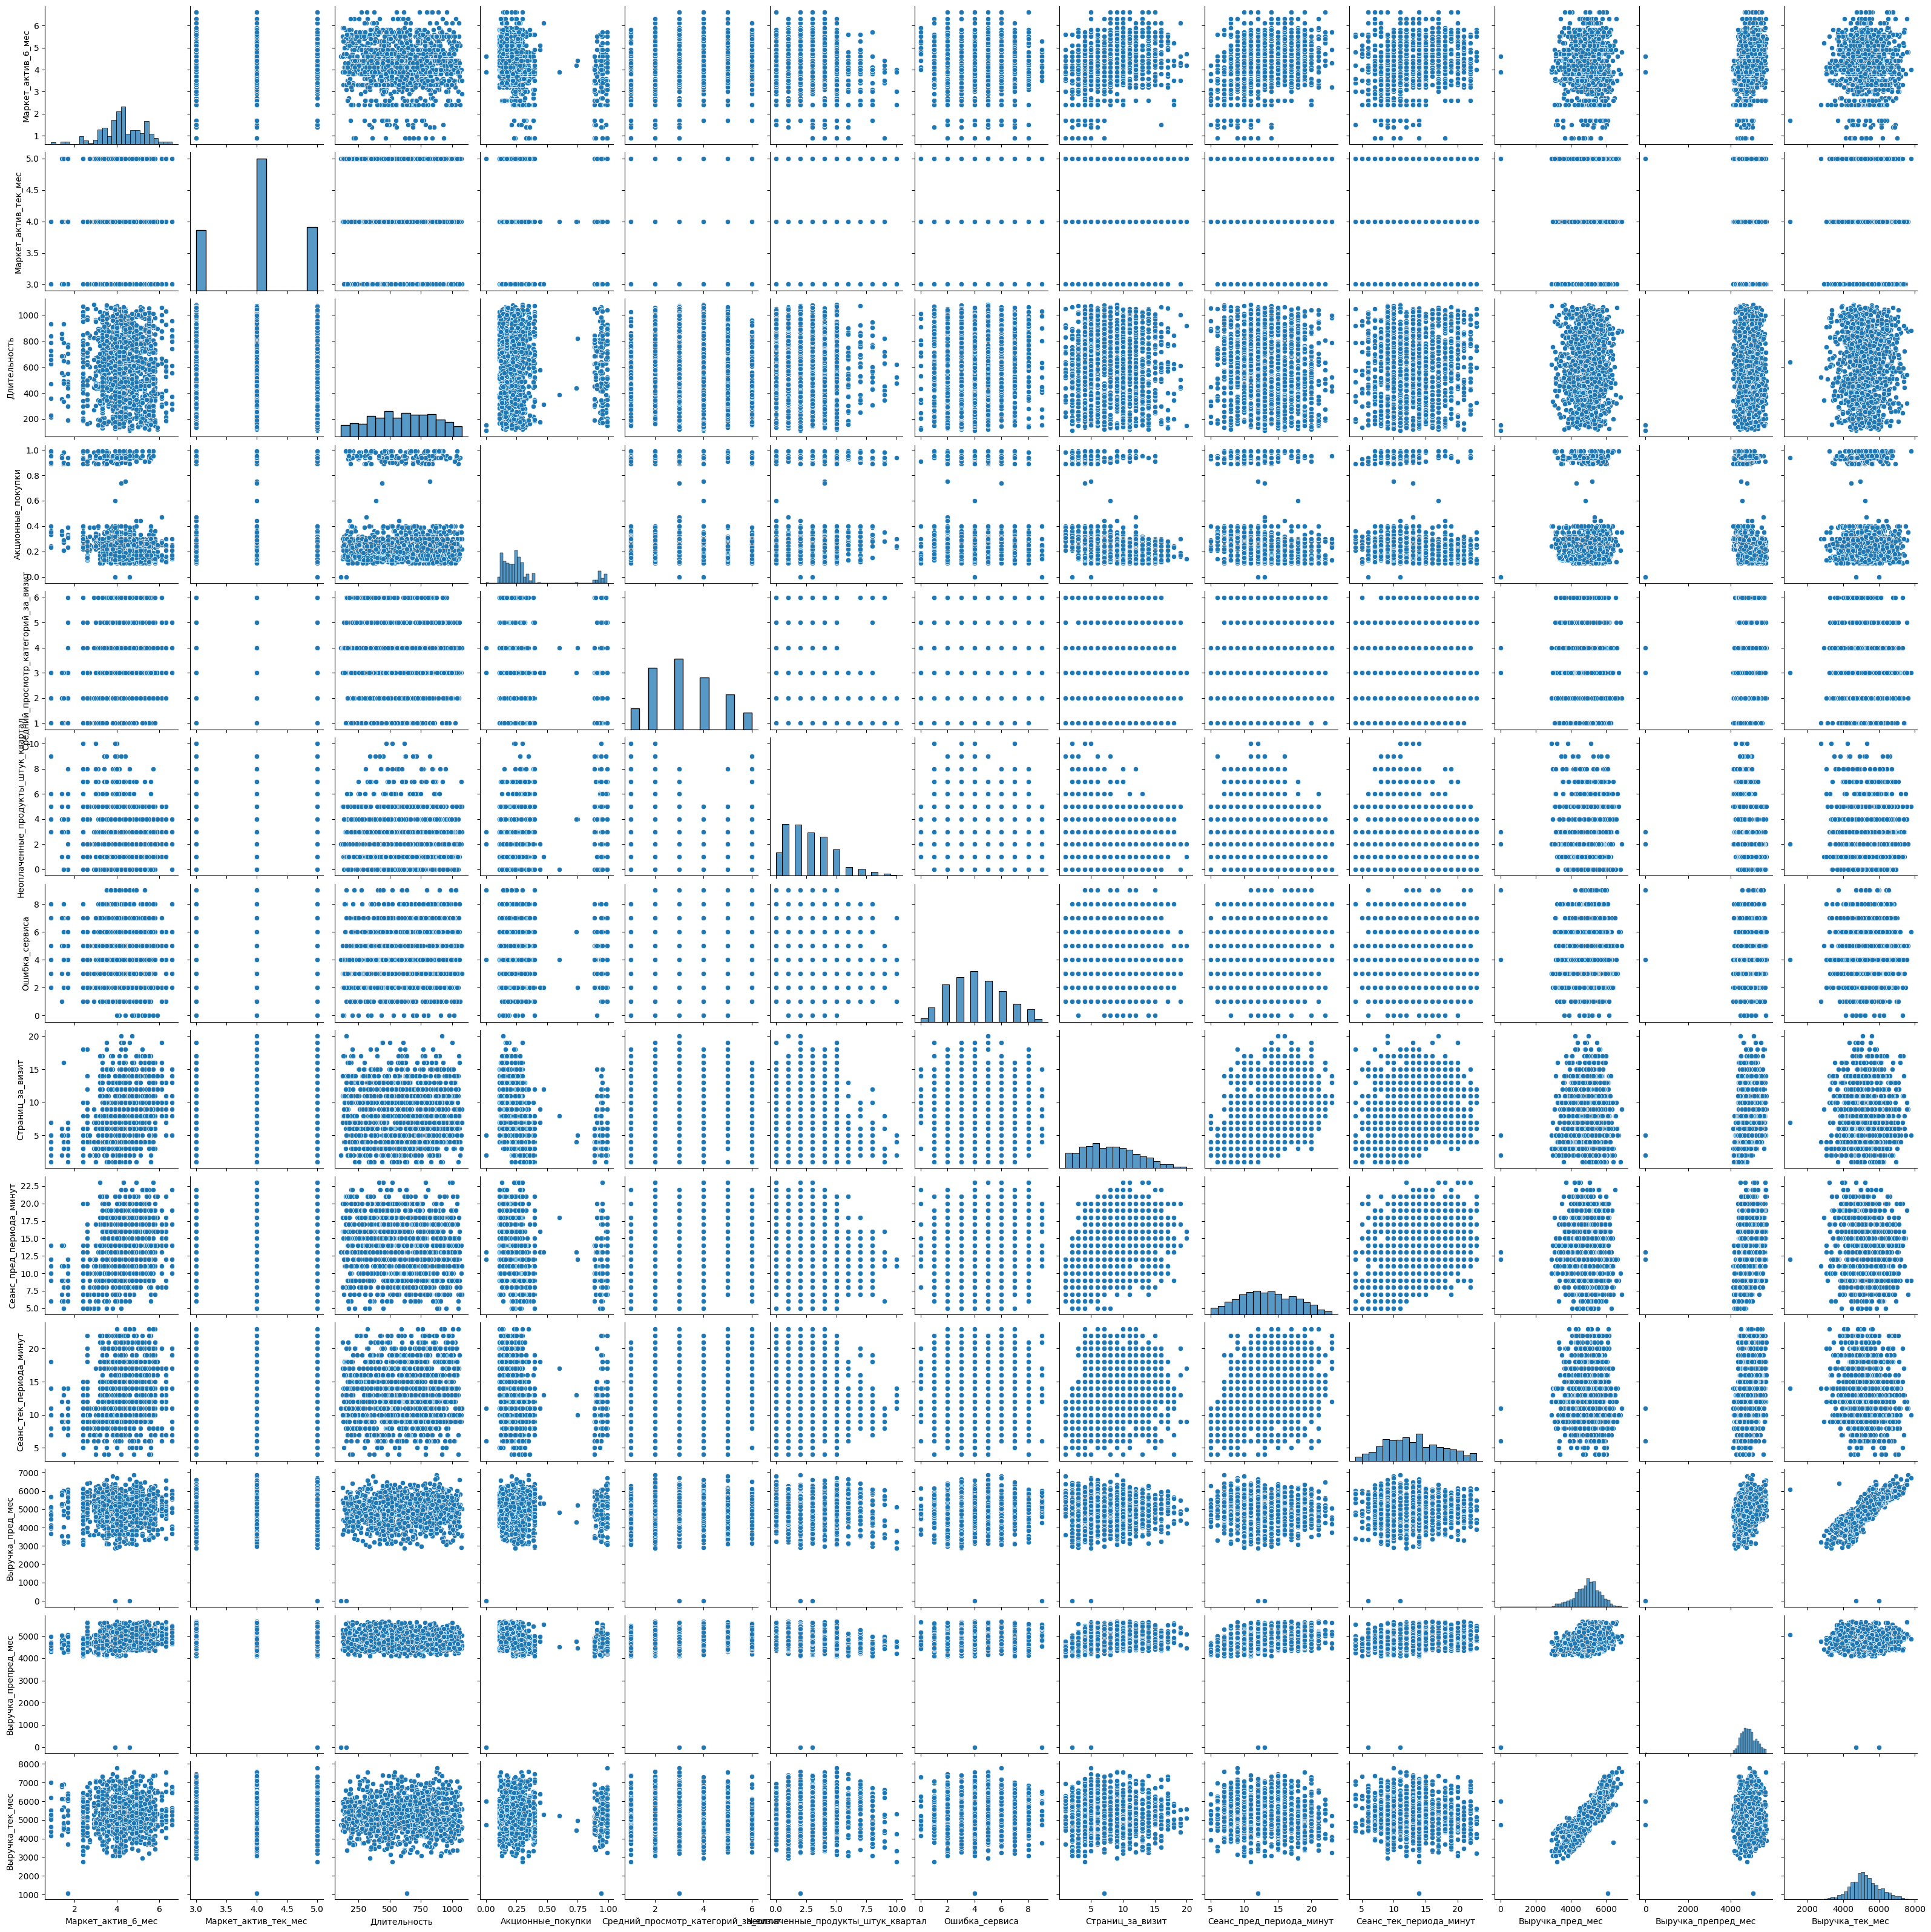

In [40]:
sns.pairplot(market_final); 
# построим диаграммы рассения попарно для каждого признака (кроме типов object) в датасете

Дополним парные диаграммы рассеяния целевым признаком для лучшей визуализации.

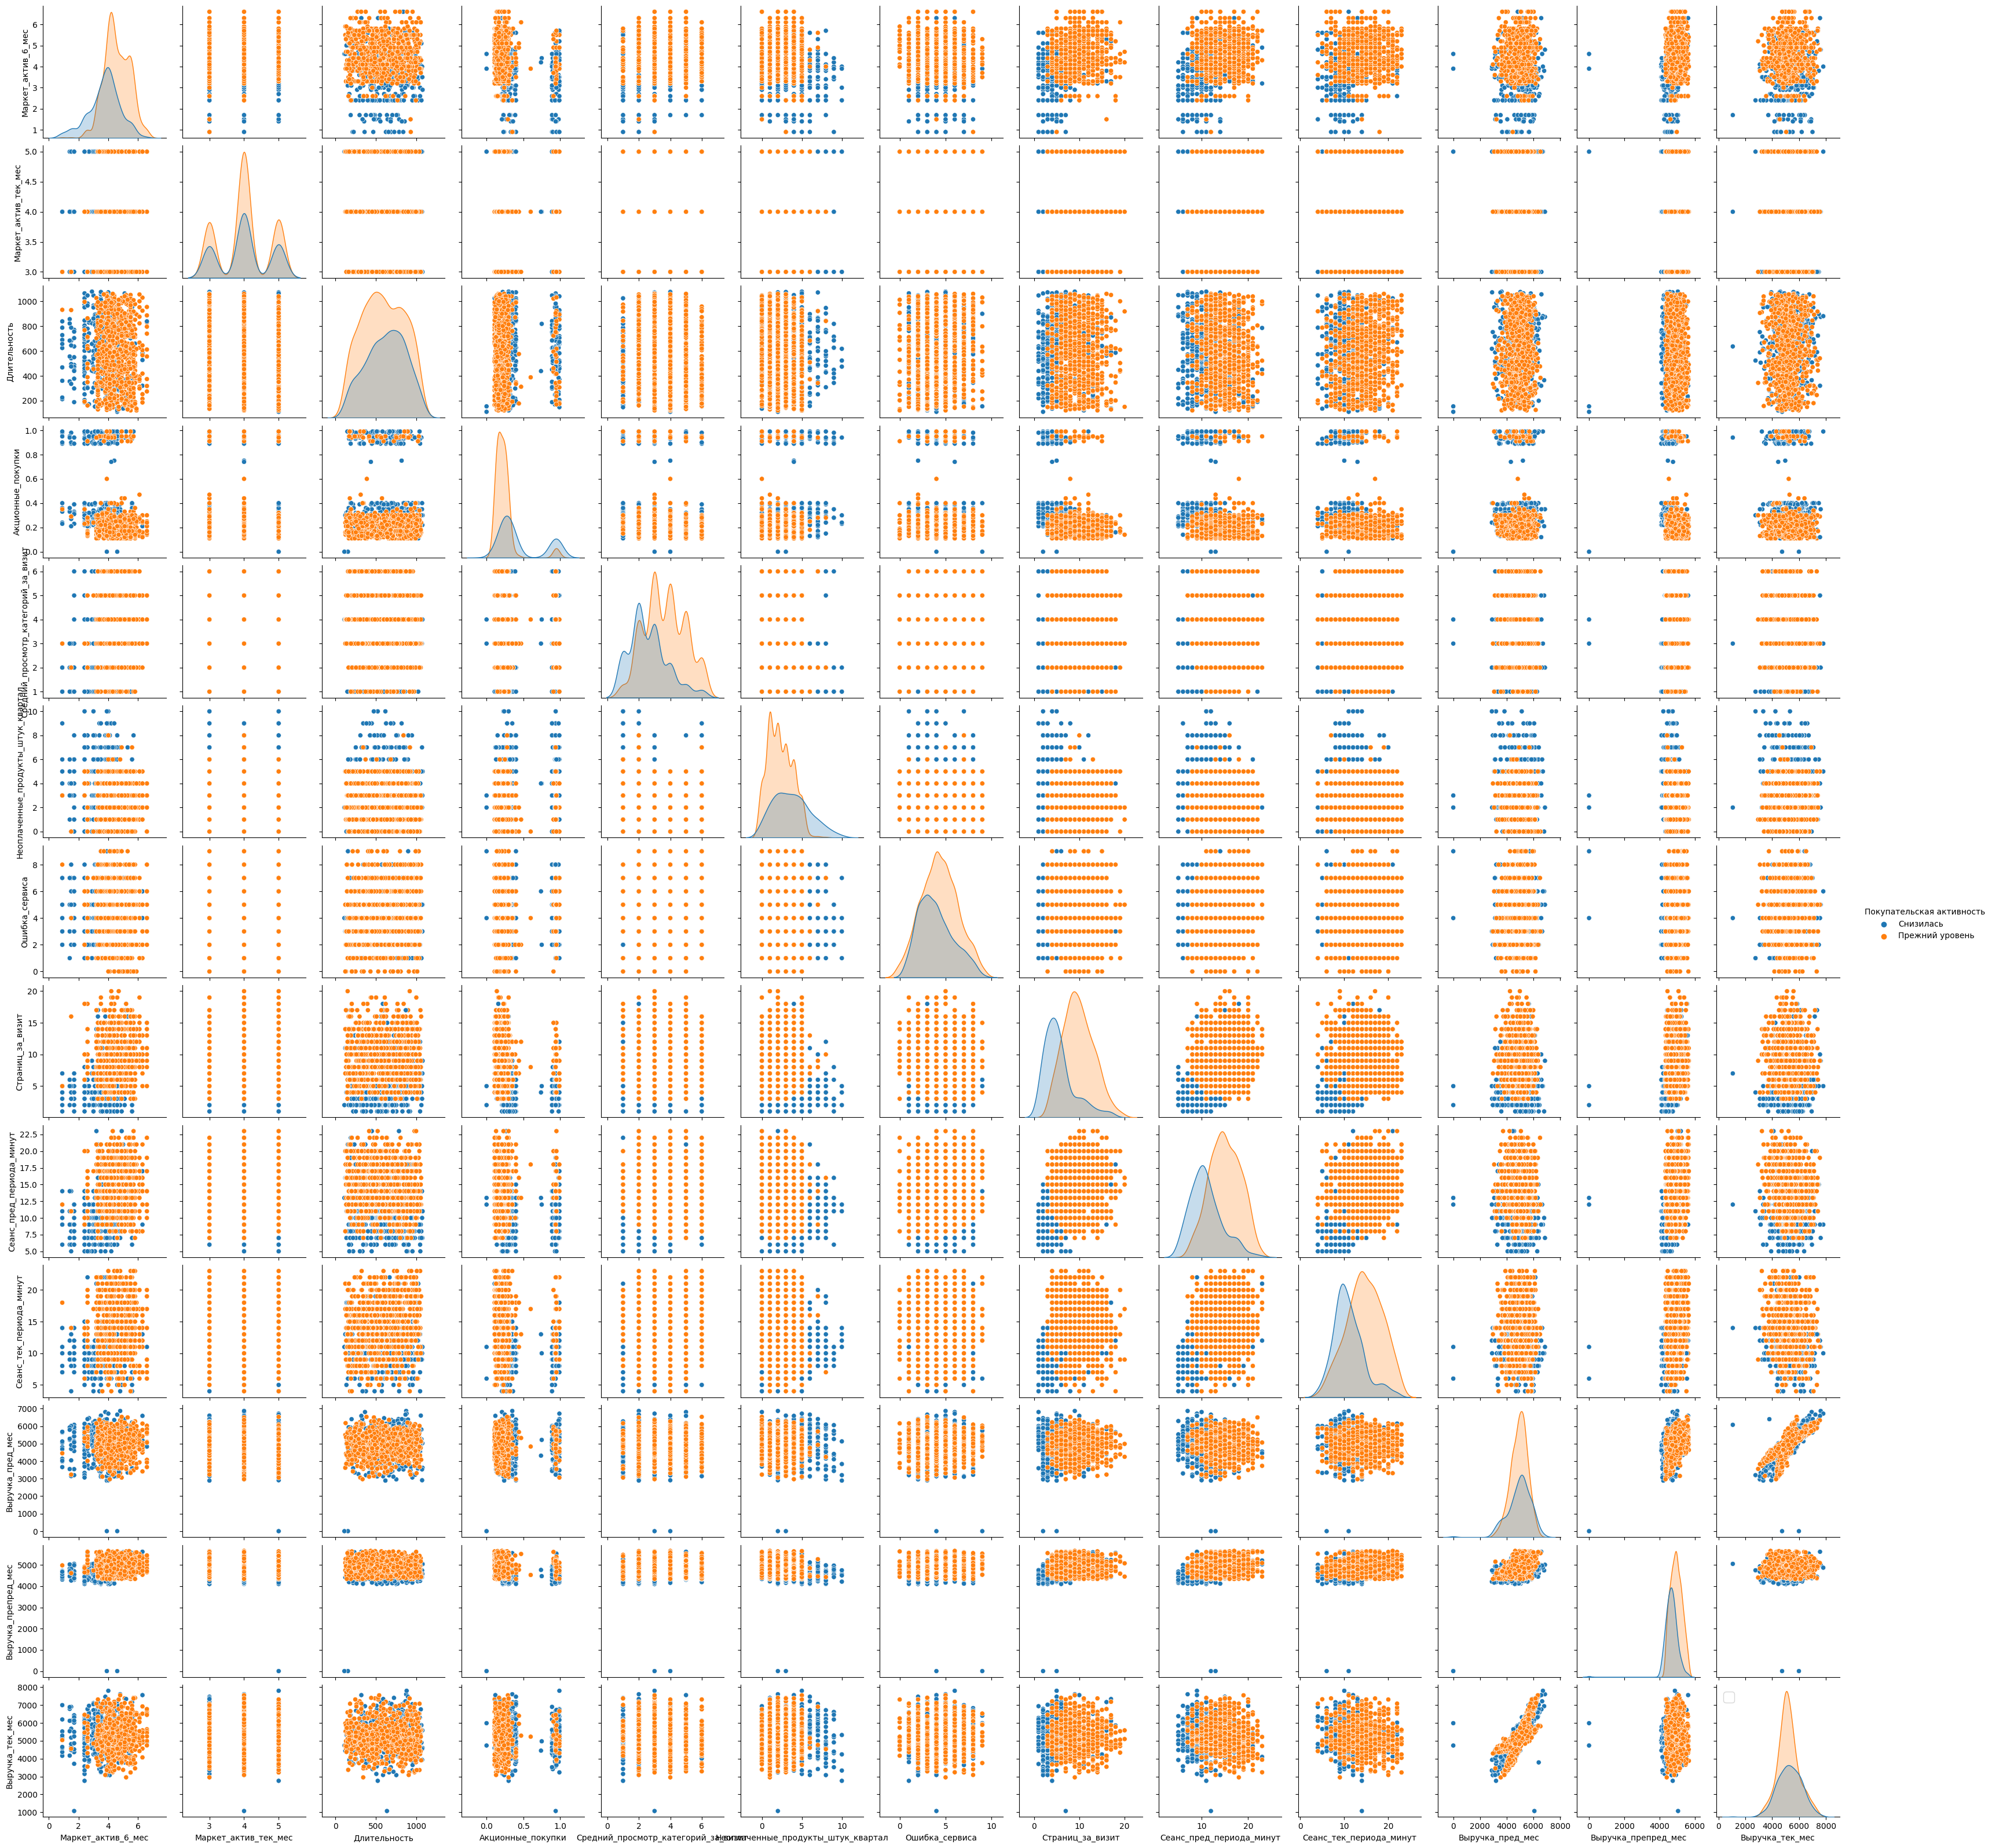

In [41]:
sns.pairplot(market_final, hue='Покупательская активность')
handles, labels = plt.gca().get_legend_handles_labels()

# Добавляем легенду на график
plt.legend(handles, labels, loc='upper left', fontsize='xx-large')
plt.rcParams['figure.figsize'] = [30, 15]

# Отображаем график с легендой
plt.show();

На парных диаграммах рассеяния линейная связь представленых признаков отсутствует (кроме выручки за текущий и предыдущий месяцы). Покупательская активность в своих значениях: снижение или прежний уровень - имеет различные величины на разных признаках: т.е. для части признаков более высокие размеры характерны для сниженной активности, на других - для прежней.

В рамках корреляционного анализа построены матрица корреляции и диаграммы рассеяния. 
По матрице на покупательскую активность не влияют (коэффицент равен нулю) наличие разрешений на уведомление, маркетинговые активности в текущем месяце, длительность регистрации. Наибольшая связь покупательской активности имеется со следующими признаками: количество страниц за визит (0.75), продолжительность просмотра в предыдущий период (0.6), продолжительность просмотра в текущем периоде (0.57), маркетинговые активности за полгода (0.55), количество просмотренных категорий (0.54), акционные покупки (0.5). Мультиколлинеарность входных признаков (коэффициент от 0.9) отсутствует. 

**<h3>Пайплайны</h3>**

Далее создадим пайплайн для четырех моделей машинного обучения

In [42]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
#label_encoder = LabelEncoder()
#market_final['Покупательская активность'] = label_encoder.fit_transform(market_final['Покупательская активность'])
#columns_label_encode = [ 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
#for col in columns_label_encode:
    #market_final[col] = label_encoder.fit_transform(market_final[col])
#display(market_final[['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']].apply(pd.value_counts))  
#market_final[[ 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']] = label_encoder.fit_transform(market_final[[ 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']])
X_train, X_test, y_train, y_test = train_test_split(
    market_final.drop(['Покупательская активность'], axis=1),
    market_final['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_final['Покупательская активность'])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = [ 'Разрешить сообщать', 'Популярная_категория']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 
              'Акционные_покупки', 'Средний_просмотр_категорий_за_визит','Длительность', 'Неоплаченные_продукты_штук_квартал',
              'Ошибка_сервиса', 'Страниц_за_визит', 'Сеанс_пред_периода_минут', 'Сеанс_тек_периода_минут',
              'Выручка_пред_мес', 'Выручка_препред_мес', 'Выручка_тек_мес']
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
             categories=[
                  ['стандарт', 'премиум'], 
             ],
             handle_unknown='use_encoded_value', unknown_value=np.nan
          )
      ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
   ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели SVC() 
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf', 'poly'],
        'models__degree': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc', # используем данную метрику, поскольку она является всеохватывающей метрикой качества
    # классификации, учитывает работу моделей на разных порогах
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке

# рассчитайте прогноз на тестовых данных
#y_test_pred = randomized_search.predict(X_test)
#print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1] 
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   

Получаем данные о том, что лучшей моделью является модель классификации опорных векторов SVC (ядро 'poly', степень 2). Значение метрики roc_auc на тренировочной выборке для этой модели - 0.9019, на тестовой - 0.9064. С учетом небольшой разницы в размере метрик и использования невысокой степени признаки переобучения отсутствуют. 

**<h3>Важность признаков</h3>**

Оценим влияние каждого входного признака на прогноз покупательской активности с помощью метода SHAP.

  0%|          | 0/20 [00:00<?, ?it/s]

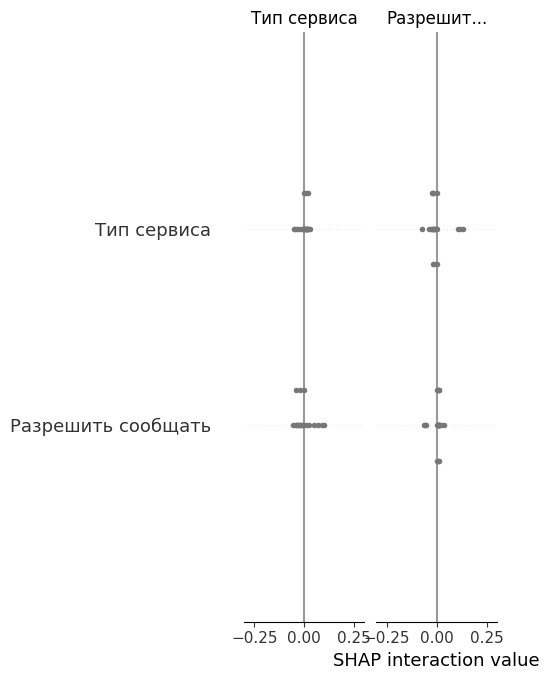

In [43]:
LIMIT = 20
explainer = shap.KernelExplainer(randomized_search.predict_proba, X_test[:LIMIT], keep_index=True)
shap_values = explainer.shap_values(X_test[:LIMIT])
shap.summary_plot(shap_values, X_test[:LIMIT])

Согласно графику, наибольшее влияние на покупательскую активность оказывают число просмотренных страниц, покупки по акциям, продолжительность нахождения на сайте, число неоплаченных продуктов, средний просмотр категорий за визит,маркетинговые активности за полгода. Эти данные говорят бизнесу о том, что маркетинговые активности приносят свой вклад в удержание пользователей, время нахождения пользователя на сайте означает, что он предпринимает действия, завершающиеся покупкой, а не бесцельно просматривает сайт, пользователи обращают внимание на скидки и важно решить вопрос с неоплаченными товарами. 

**<h3>Сегментация пользователей</h3>**

Применим лучшую модель для предсказания покупательской активности пользователей (в сторону снижения).

In [44]:
X = market_final.drop('Покупательская активность', axis=1)
predictions = randomized_search.predict_proba(X)[:, 1]
market_final['predictions'] = predictions
market_final.head()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   
215354                 Снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   
215354                 5.1                     3           431   

        Акционные_покупки   Популярная_категория  \
id                                                 
215349               0.75       Товары для детей   
215351               0.99       Товары для детей   
215352               0.94       Товары для детей   
215353               0.26      Домашний текстиль   
215354               0.23  Косметика и аксесуары   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215351                                    5   
215352                                    3   
215353                                    4   
215354                                    2   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   
215354                                   3               7                 2   

        Сеанс_пред_периода_минут  Сеанс_тек_периода_минут  Выручка_пред_мес  \
id                                                                            
215349                        12                       10            5216.0   
215351                        11                       13            6158.0   
215352                         8                       11            5807.5   
215353                        10                       10            4738.5   
215354                        11                       12            5685.0   

        Выручка_препред_мес  Выручка_тек_мес  predictions  
id                                                         
215349               4472.0           4971.6     0.930736  
215351               4793.0           6610.4     0.921089  
215352               4594.0           5872.5     0.912704  
215353               5124.0           5388.5     0.885118  
215354               4503.0           5869.6     0.676291

In [45]:
# создадим столбец с суммой выручки по каждому пользователю за три месяца
market_final['Общая_выручка_3_мес'] = market_final['Выручка_пред_мес'] + \
    market_final['Выручка_препред_мес'] + market_final['Выручка_тек_мес']
market_final.head()    

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   
215354                 Снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   
215354                 5.1                     3           431   

        Акционные_покупки   Популярная_категория  \
id                                                 
215349               0.75       Товары для детей   
215351               0.99       Товары для детей   
215352               0.94       Товары для детей   
215353               0.26      Домашний текстиль   
215354               0.23  Косметика и аксесуары   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215351                                    5   
215352                                    3   
215353                                    4   
215354                                    2   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   
215354                                   3               7                 2   

        Сеанс_пред_периода_минут  Сеанс_тек_периода_минут  Выручка_пред_мес  \
id                                                                            
215349                        12                       10            5216.0   
215351                        11                       13            6158.0   
215352                         8                       11            5807.5   
215353                        10                       10            4738.5   
215354                        11                       12            5685.0   

        Выручка_препред_мес  Выручка_тек_мес  predictions  Общая_выручка_3_мес  
id                                                                              
215349               4472.0           4971.6     0.930736              14659.6  
215351               4793.0           6610.4     0.921089              17561.4  
215352               4594.0           5872.5     0.912704              16274.0  
215353               5124.0           5388.5     0.885118              15251.0  
215354               4503.0           5869.6     0.676291              16057.6

In [46]:
market_final.reset_index(inplace=True) # вернем в датасет столбец с id покупателей для корректного добавления столбца с прибылью
market_final.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215351                 Снизилась    стандарт                 да   
2  215352                 Снизилась    стандарт                нет   
3  215353                 Снизилась    стандарт                 да   
4  215354                 Снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 3.2                     5           896               0.99   
2                 5.1                     3          1064               0.94   
3                 3.3                     4           762               0.26   
4                 5.1                     3           431               0.23   

    Популярная_категория  Средний_просмотр_категорий_за_визит  \
0       Товары для детей                                    4   
1       Товары для детей                                    5   
2       Товары для детей                                    3   
3      Домашний текстиль                                    4   
4  Косметика и аксесуары                                    2   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   4               2                 5   
1                                   0               6                 4   
2                                   2               3                 2   
3                                   1               1                 4   
4                                   3               7                 2   

   Сеанс_пред_периода_минут  Сеанс_тек_периода_минут  Выручка_пред_мес  \
0                        12                       10            5216.0   
1                        11                       13            6158.0   
2                         8                       11            5807.5   
3                        10                       10            4738.5   
4                        11                       12            5685.0   

   Выручка_препред_мес  Выручка_тек_мес  predictions  Общая_выручка_3_мес  
0               4472.0           4971.6     0.930736              14659.6  
1               4793.0           6610.4     0.921089              17561.4  
2               4594.0           5872.5     0.912704              16274.0  
3               5124.0           5388.5     0.885118              15251.0  
4               4503.0           5869.6     0.676291              16057.6

In [47]:
market_final['Прибыль'] = money['Прибыль']
display(market_final.head())
market_final.info()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215351                 Снизилась    стандарт                 да   
2  215352                 Снизилась    стандарт                нет   
3  215353                 Снизилась    стандарт                 да   
4  215354                 Снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 3.2                     5           896               0.99   
2                 5.1                     3          1064               0.94   
3                 3.3                     4           762               0.26   
4                 5.1                     3           431               0.23   

    Популярная_категория  Средний_просмотр_категорий_за_визит  ...  \
0       Товары для детей                                    4  ...   
1       Товары для детей                                    5  ...   
2       Товары для детей                                    3  ...   
3      Домашний текстиль                                    4  ...   
4  Косметика и аксесуары                                    2  ...   

   Ошибка_сервиса  Страниц_за_визит  Сеанс_пред_периода_минут  \
0               2                 5                        12   
1               6                 4                        11   
2               3                 2                         8   
3               1                 4                        10   
4               7                 2                        11   

   Сеанс_тек_периода_минут  Выручка_пред_мес  Выручка_препред_мес  \
0                       10            5216.0               4472.0   
1                       13            6158.0               4793.0   
2                       11            5807.5               4594.0   
3                       10            4738.5               5124.0   
4                       12            5685.0               4503.0   

   Выручка_тек_мес  predictions  Общая_выручка_3_мес  Прибыль  
0           4971.6     0.930736              14659.6     0.98  
1           6610.4     0.921089              17561.4     4.16  
2           5872.5     0.912704              16274.0     3.13  
3           5388.5     0.885118              15251.0     4.87  
4           5869.6     0.676291              16057.6     4.21  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1294 non-null   int64  
 1   Покупательская активность            1294 non-null   object 
 2   Тип сервиса                          1294 non-null   object 
 3   Разрешить сообщать                   1294 non-null   object 
 4   Маркет_актив_6_мес                   1294 non-null   float64
 5   Маркет_актив_тек_мес                 1294 non-null   int64  
 6   Длительность                         1294 non-null   int64  
 7   Акционные_покупки                    1294 non-null   float64
 8   Популярная_категория                 1294 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1294 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1294 non-null   int64  
 11  Ошибка_сервиса                

In [48]:
market_final['Прибыль'].describe() # получим статистические данные по прибыли

count    1294.000000
mean        3.994467
std         1.012888
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

Значения прибыли представлены от 0.86 до 7.43. Можно было бы предположить, что это коэффициенты со снижением прибыли в рублях в 1000 раз. Но по первым пяти строкам датасета видно, что, даже с учетом вычета расходов прибыль 4.16 (к примеру) мало соотносится с выручкой за три месяца в размере 14 659.6. И прибыль может быть схожей (4.16 и 4.21), в то время как размеры выручки значительно отличаются (14 659.6 и 16 274). В отсутствие пояснений от заказчика не будем выявлять взаимосвязи этих величин, но при сегментации пользователей совместно эти признаки использовать не будем.  

Построим диаграмму рассеяния для визуализации связи между прогнозом покупательской активности и прибылью от пользователя.

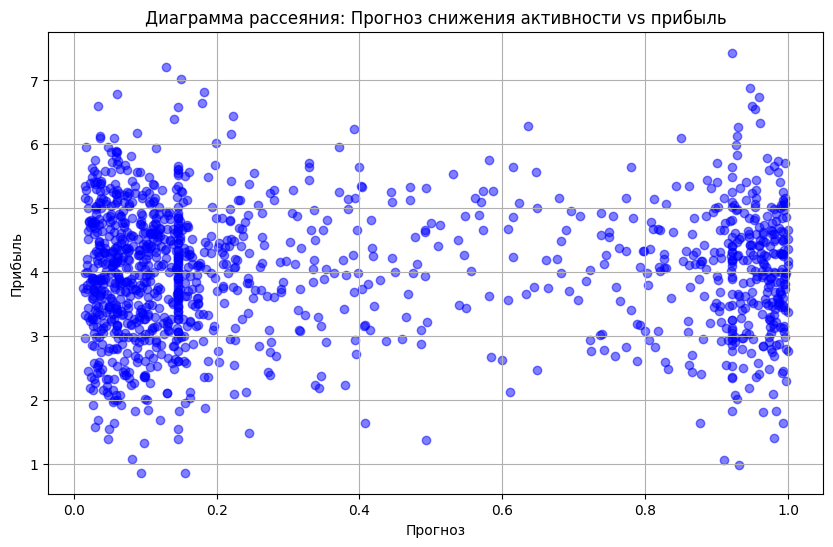

In [49]:
x = market_final['predictions']
y = market_final['Прибыль']

# Построение scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.5)
plt.title('Диаграмма рассеяния: Прогноз снижения активности vs прибыль')
plt.xlabel('Прогноз')
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

Из диаграммы следует, что величина прибыли больше у тех пользователей, покупательская активность которых сохраняется.
Также видим, что пользователей, у которых по прогнозу покупательская активность снизится (прогноз ближе к 1), можно разделить на три группы в зависимости от размера прибыли: до 2, от 2 до 6, более 6. Наиболее многочисленна группа, приносящая прибыль от 2 до 6. Подсчитаем число таких пользователей данной группы.

In [50]:
market_final.query('(Прибыль >= 2 and Прибыль <= 6) and predictions >= 0.8')['id'].count()

324

Получили информацию о том, что таких пользователей 324, или 25% от всех пользователей. То есть магазин рискует потерять покупки почти четверть своих покупателей. Определим, какую выручку они приносят.

In [51]:
market_final.query('(Прибыль >= 2 and Прибыль <= 6) and predictions >= 0.8')['Общая_выручка_3_мес'].sum() / market_final['Общая_выручка_3_мес'].sum()

0.24738024732859581

Эта группа пользователей приносит 24.73% выручки магазину (чуть меньше своей доли в числе пользователей). Посмотрим, свойственно ли им покупать товары по акциям, и какие категории товаров у них популярны. 

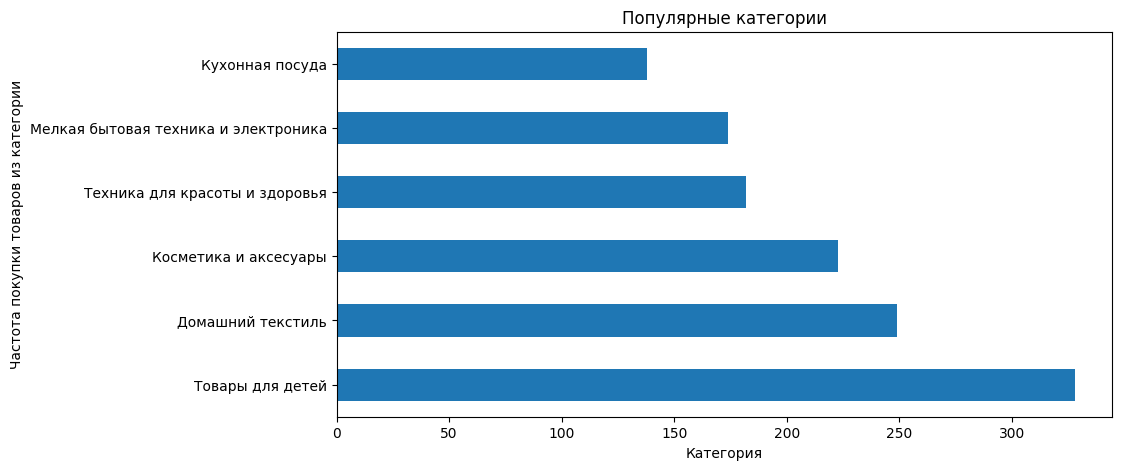

In [52]:
market_final['Популярная_категория'].value_counts().plot(kind='barh', title='Популярные категории', figsize=(10, 5))
plt.xlabel('Категория')
plt.ylabel('Частота покупки товаров из категории')
plt.show()

In [53]:
display(market_final.query('(Прибыль >= 2 and Прибыль <= 6) and predictions >= 0.8')['Акционные_покупки'].count() / len(market_final))
market_final.query('(Прибыль >= 2 and Прибыль <= 6) and predictions >= 0.8 and Популярная_категория == "Товары для детей"')['Популярная_категория'].count() \
/ market_final.query('Популярная_категория == "Товары для детей"')['Популярная_категория'].count()

0.250386398763524

0.3079268292682927

Получили данные о том, что рассматриваемая группа совершает 25% покупок по акциям (пропорционально своей доле в числе пользователей). При этом по самой продаваемой категории (товары для детей) рассматриваемая группа приобретает почти 31% товаров (то есть больше, чем размер доли таких пользователей от общей массы платящих пользователей).
С учетом того, что имеются специализированные интернет-магазины детских товаров, высокая доля детских товаров в продажах магазина-заказчика подтверждает, что заказчик сумел подобрать ассортимент и установить прейскурант, удовлетворяющий интересы пользователей. А с учетом того, что всего в магазине заказчика представлено шесть категорий товаров, это означает интерес пользователей к товарам для детей (и наличие у них детей). Поскольку наибольшее число товаров для детей обычно (разумное предположение) представлено для возрастной группы до семи лет (нужно часто менять одежду, использовать специальный рацион, игрушки и т.п.) и дети пользователей растут, а поиск новых пользователей (в т.ч. с маленькими детьми) затруднен, заказчику следует обратить внимание на более старшую детскую возрастную группу и расширить ассортимент товаров для детей старше 7 лет, включая подростковый сегмент (10-18 лет). Вероятно, снижение покупательской активности происходит и по той причине, что по мере взросления детей родители-пользователи перестают совершать покупки в интернет-магазине заказчика, и ищут иные альтернативы. Возможно отдельно разработать  категорию товаров "Teenagers choice", куда включить позиции из косметики, техники для красоты, электроники; сегментом пользователей такого раздела  будут и родители, и подростки, напрямую приобретающие товары.  

В данном разделе по прогнозу снижения покупательской активности и прибыли от пользователей, используя диаграмму рассеяния, определили три группы пользователей, из которых далее рассмотрели самую многочисленную, с прибылью от 2 до 6.
Установили, что эта группа приносит пропорциональную своей доле в числе пользователей долю выручки, акционных покупок. Наиболее значимым оказался вклад этой группы в покупки товаров для детей (самая популярная категория продаваемых товаров). Рекомендовано расширить ассортимент детских товаров на старшию возрастную группу, включить категорию товаров для подростков.

**<h3>Итоговый вывод</h3>**

1. Задачами анализа являлись разработка модели предсказания снижения активности покупателей интернет-магазина заказчика, сегментация пользователей, варианты персонализации предложений.
2. Изначально работа велась с исходными данными в четырех датасетах, где были устранены неявные дубликаты (тип сервиса), созданы сводные таблицы для лучшей визуализации продолжительности просмотра сайта и выручки по каждому из периодов.
3. Проведена визуализация признаков. По одному из покупателей размер выручки за один из месяцев изменен ввиду несоответствия признаку снижения активности.
4. Проведено объединение трех датасетов, корреляционный анализ (матрица, диаграммы рассеяния). Выявлены некоторые расхождения в значениях коэффициентов по ряду признаков. Принято решение при обучении моделей использовать все входные признаки. Мультиколлинеарность входных признаков отсутствует.
5. По итогам применения пайплайнов определили лучшую модель (опорных векторов с ядром poly  и невысокой степенью (2), что обеспечивает простоту модели в целях пресечения переобучения), метрикой качества избрали roc_auc, которая наиболее полноценно решает задачу классификации, показывает работу модели на всех порогах.
6. По лучшей модели была определена вероятность снижения покупательской активности. В ранее объединенный датасет включены данные по общей выручке за квартал по каждому пользователю, прибыли. Ввиду неясной взаимосвязи между выручкой и прибылью (последняя указана в числах до 8) принято решение не использовать совместно эти два признака.
7. По прогнозу снижения покупательской активности и прибыли от пользователей, используя диаграмму рассеяния, определили три группы пользователей, из которыз далее рассмотрели самую многочисленную, с прибылью от 2 до 6.
Установили, что эта группа приносит пропорциональную своей доле в числе пользователей долю выручки, акционных покупок. Наиболее значимым оказался вклад этой группы в покупки товаров для детей (самая популярная катоегория продаваемых товаров). Рекомендовано расширить ассортимент детских товаров на старшию возрастную группу, включить категорию товаров для подростков.
8. Заказчику рекомендуется решить вопрос с неоплаченными товарами (брошенными корзинами, возвратом товаров), поскольку таковых имеется 1184, по одному случаю на пользователя, число неоплаченных товаров составляет до 10. Также заказчику рекомендуется устранить ошибки сервиса, которые становятся очевидными для пользоваталей. Все эти негативные моменты приводят к снижению выручки. Из проведенного анализа следует, что заказчик смог заинтересовать своим уникальным торговым предложением пользователей, но сохранение багов и постоянно высокого уровня неоплаченных товаров ведет к злоупотреблению интернет-магазином своим положением и в итоге может привести к оттоку пользователей.